
 Elaborazione: 640 px...


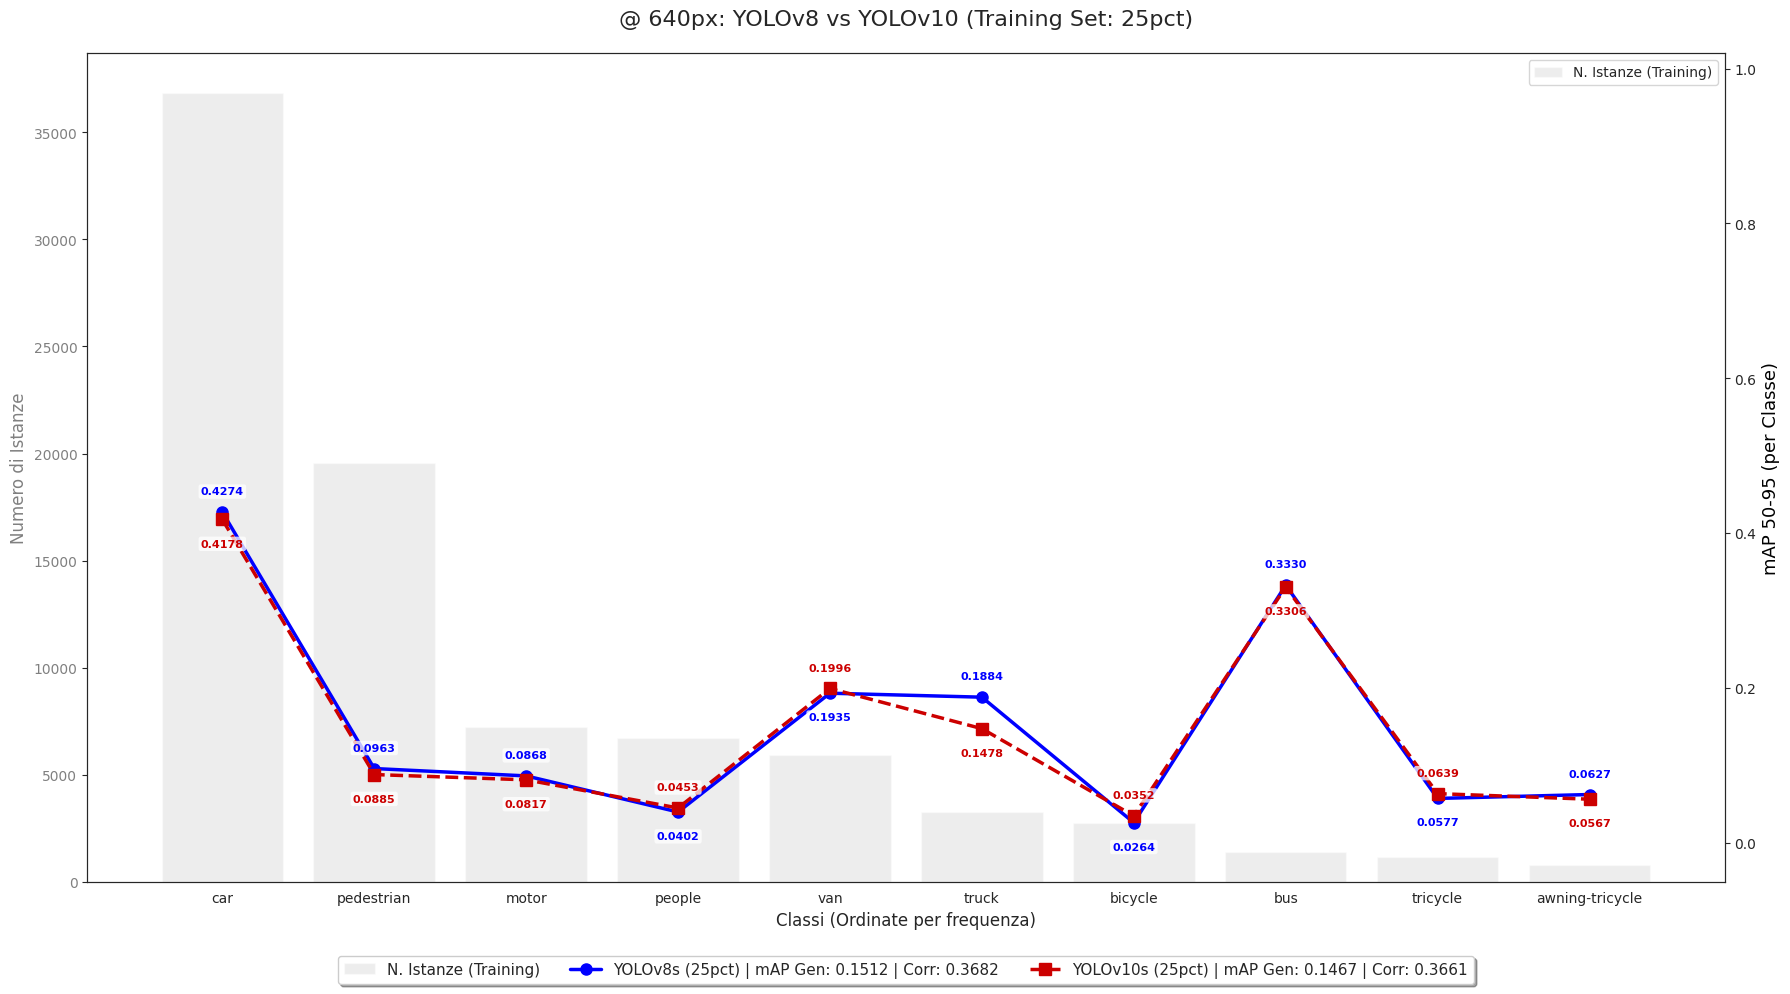

 Salvato: Grafici_Analisi_Complete_Con_Correlazione/Analisi_25pct_640px.png


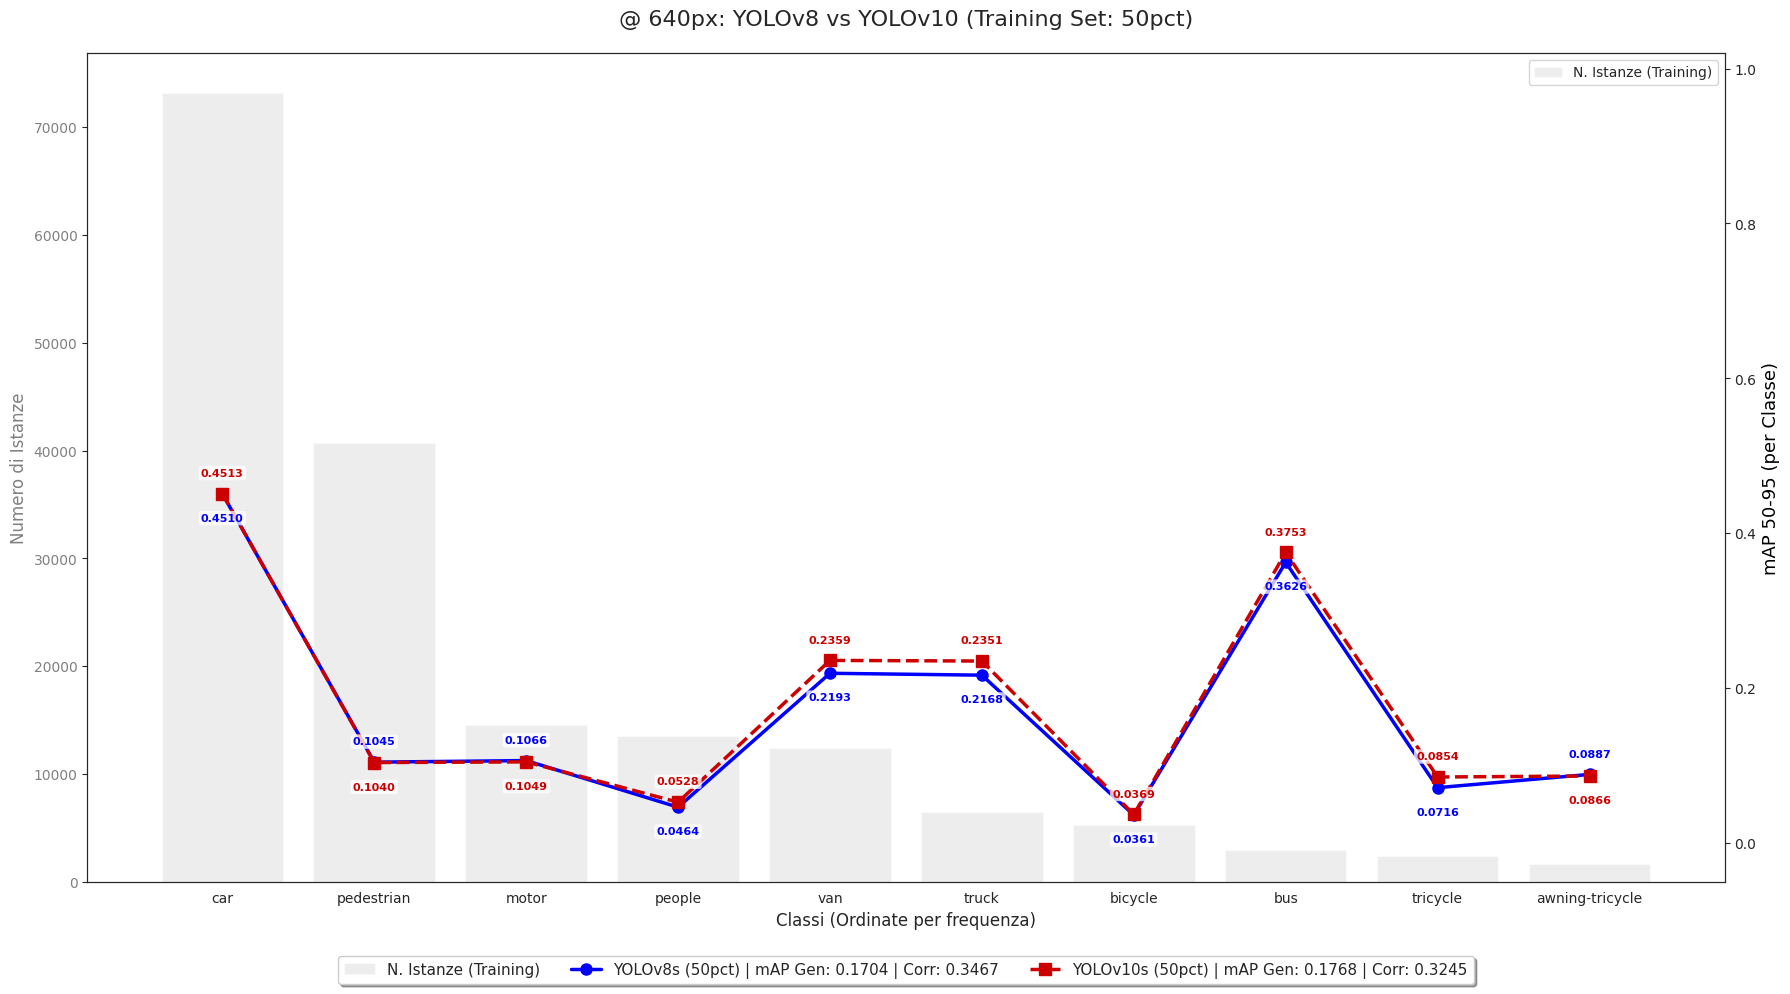

 Salvato: Grafici_Analisi_Complete_Con_Correlazione/Analisi_50pct_640px.png


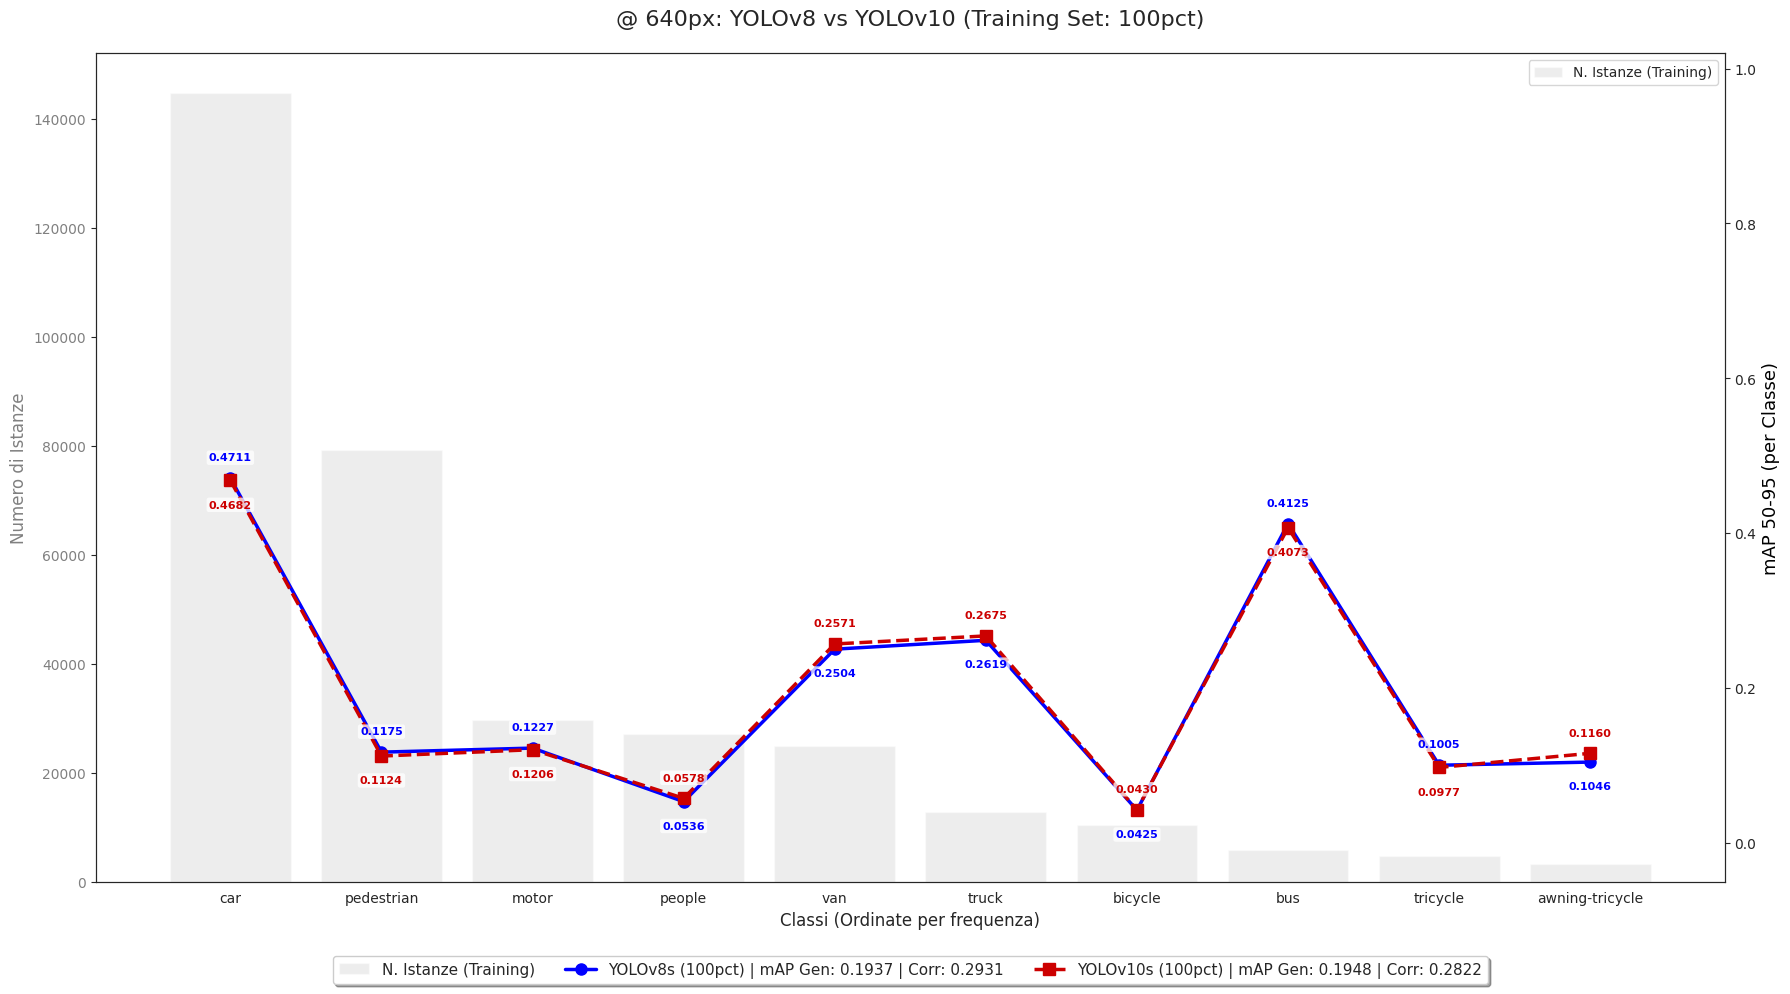

 Salvato: Grafici_Analisi_Complete_Con_Correlazione/Analisi_100pct_640px.png

 Elaborazione: 1024 px...


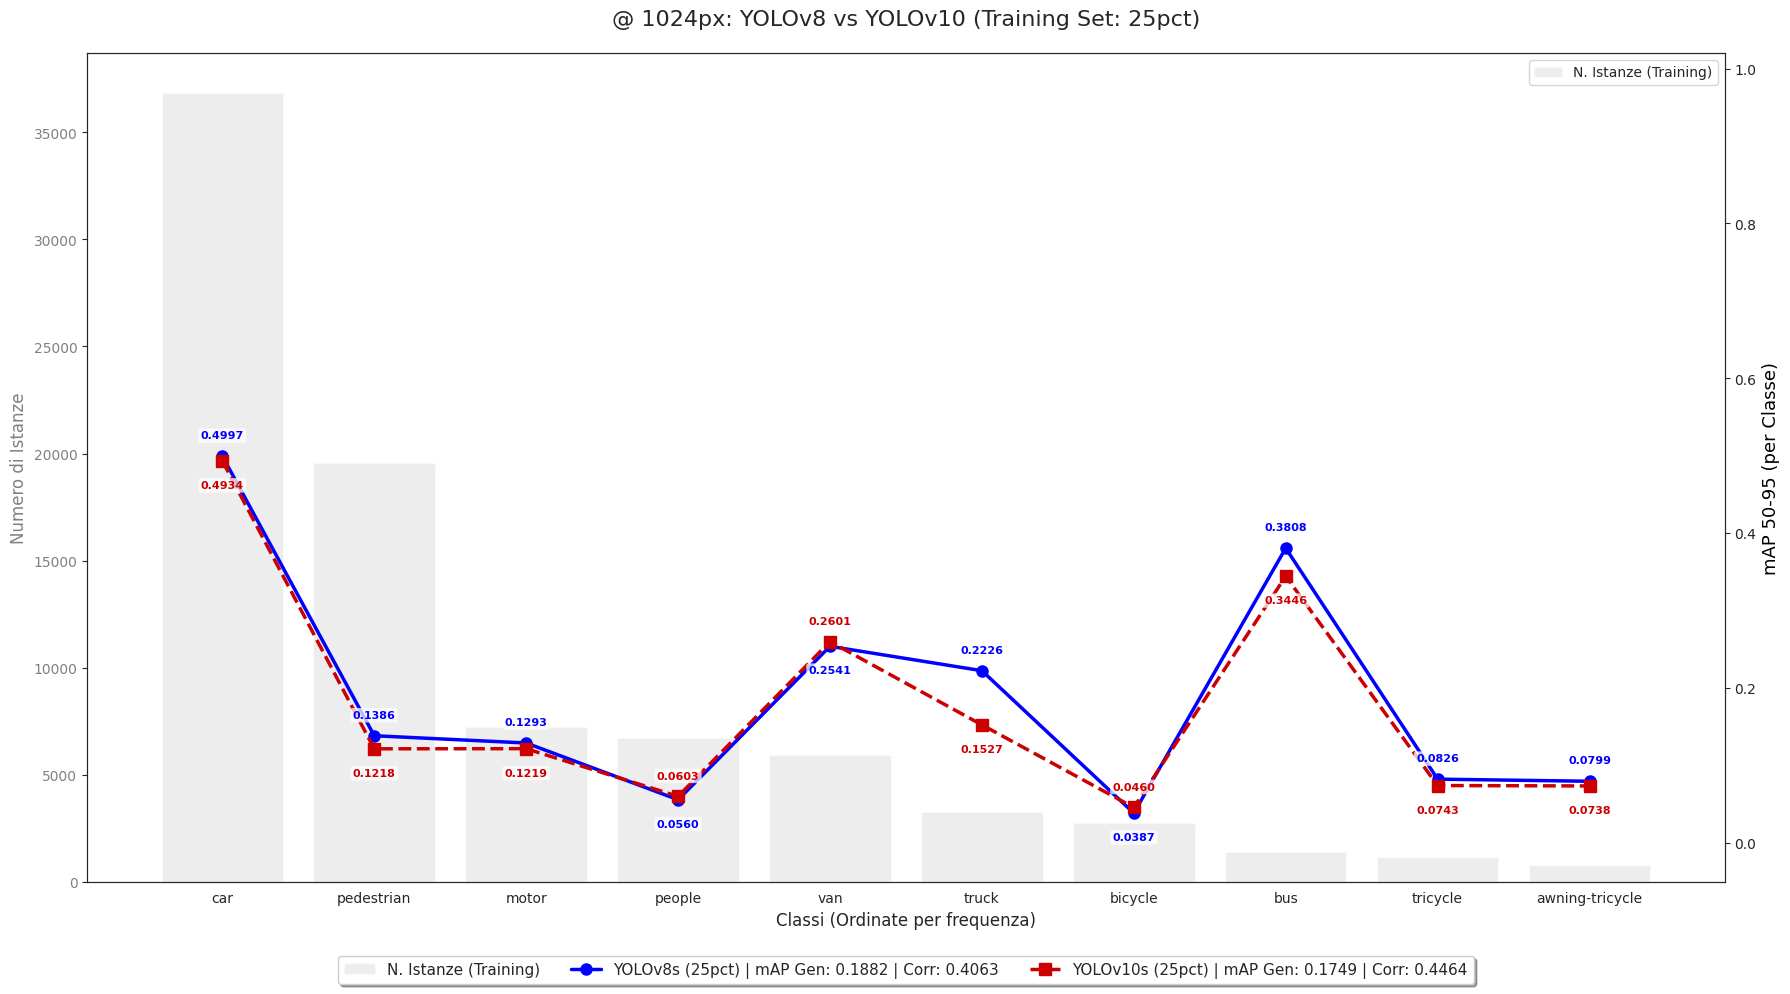

 Salvato: Grafici_Analisi_Complete_Con_Correlazione/Analisi_25pct_1024px.png


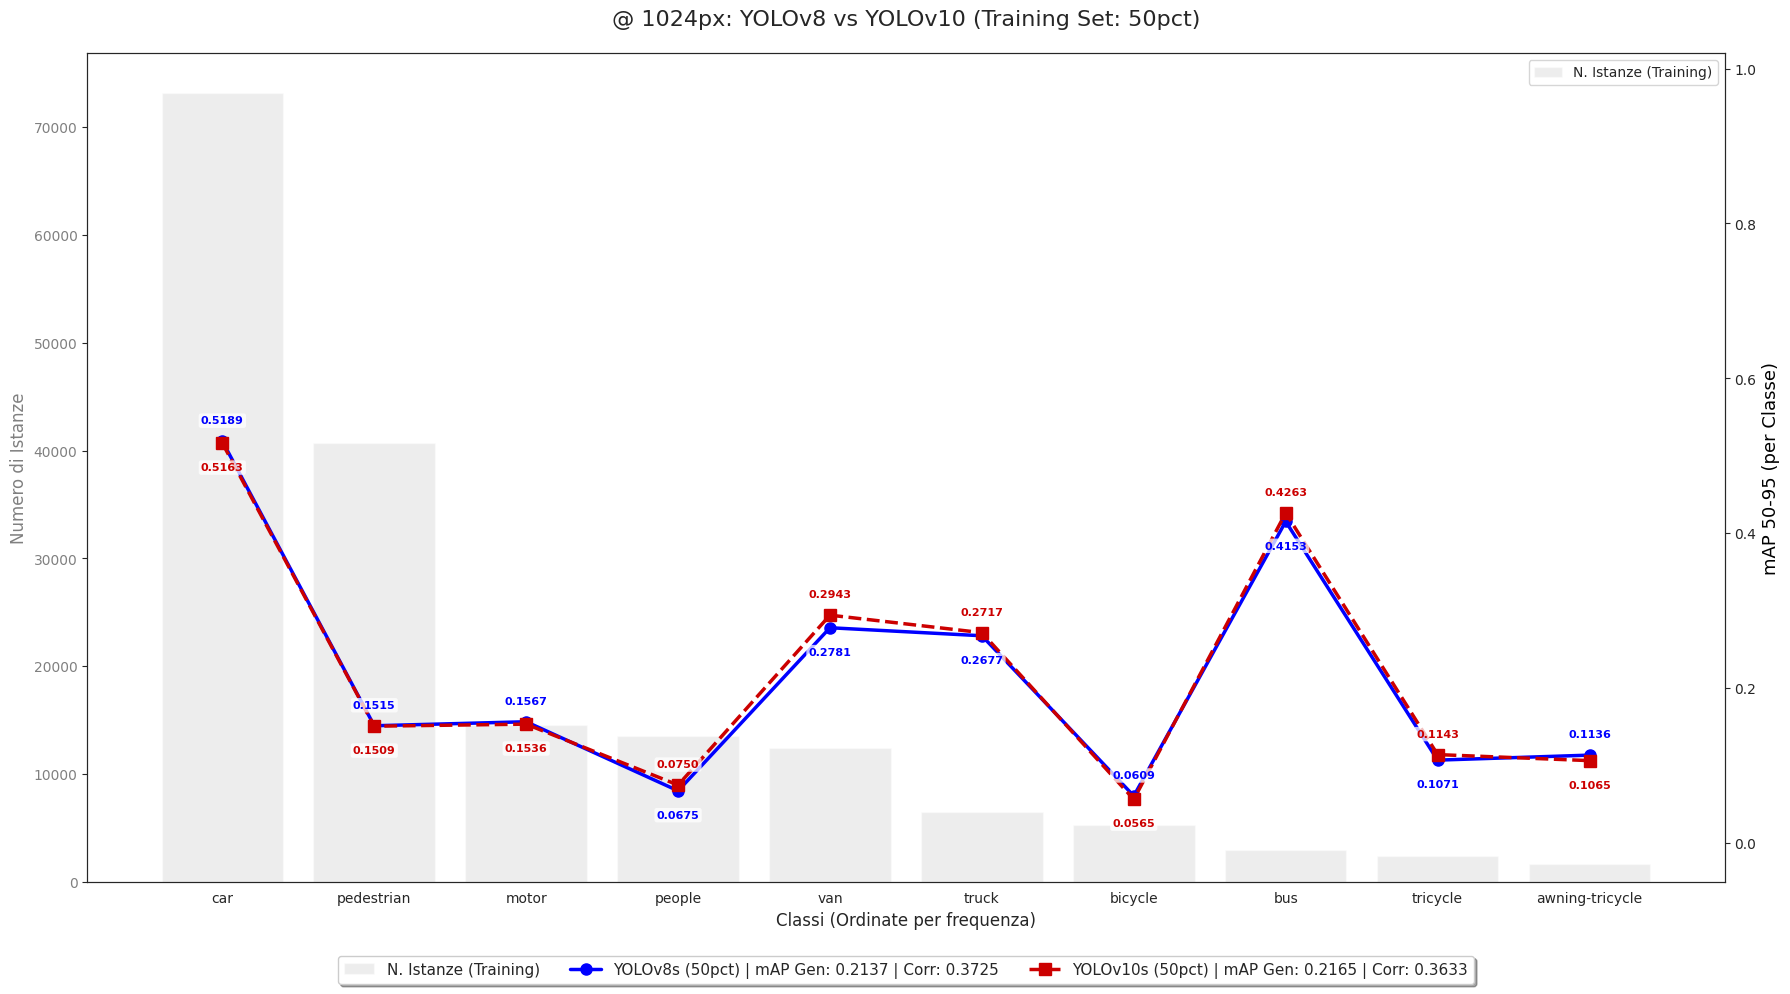

 Salvato: Grafici_Analisi_Complete_Con_Correlazione/Analisi_50pct_1024px.png


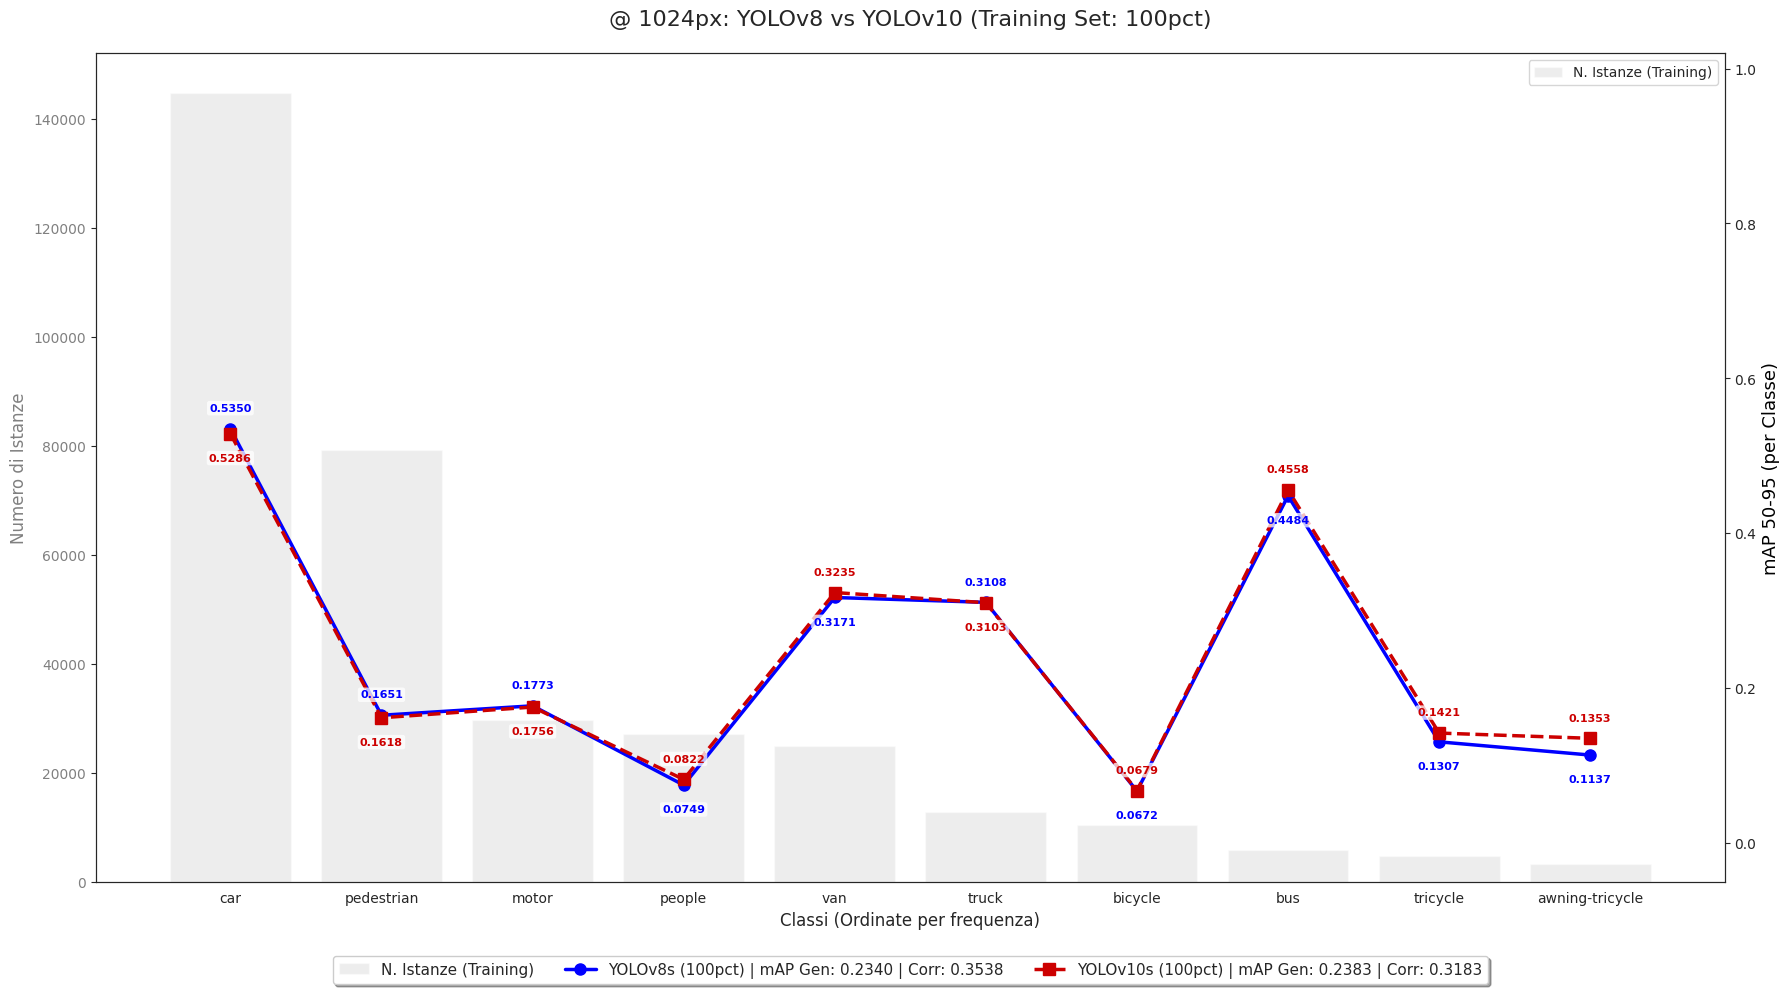

 Salvato: Grafici_Analisi_Complete_Con_Correlazione/Analisi_100pct_1024px.png

 Elaborazione: 1280 px...


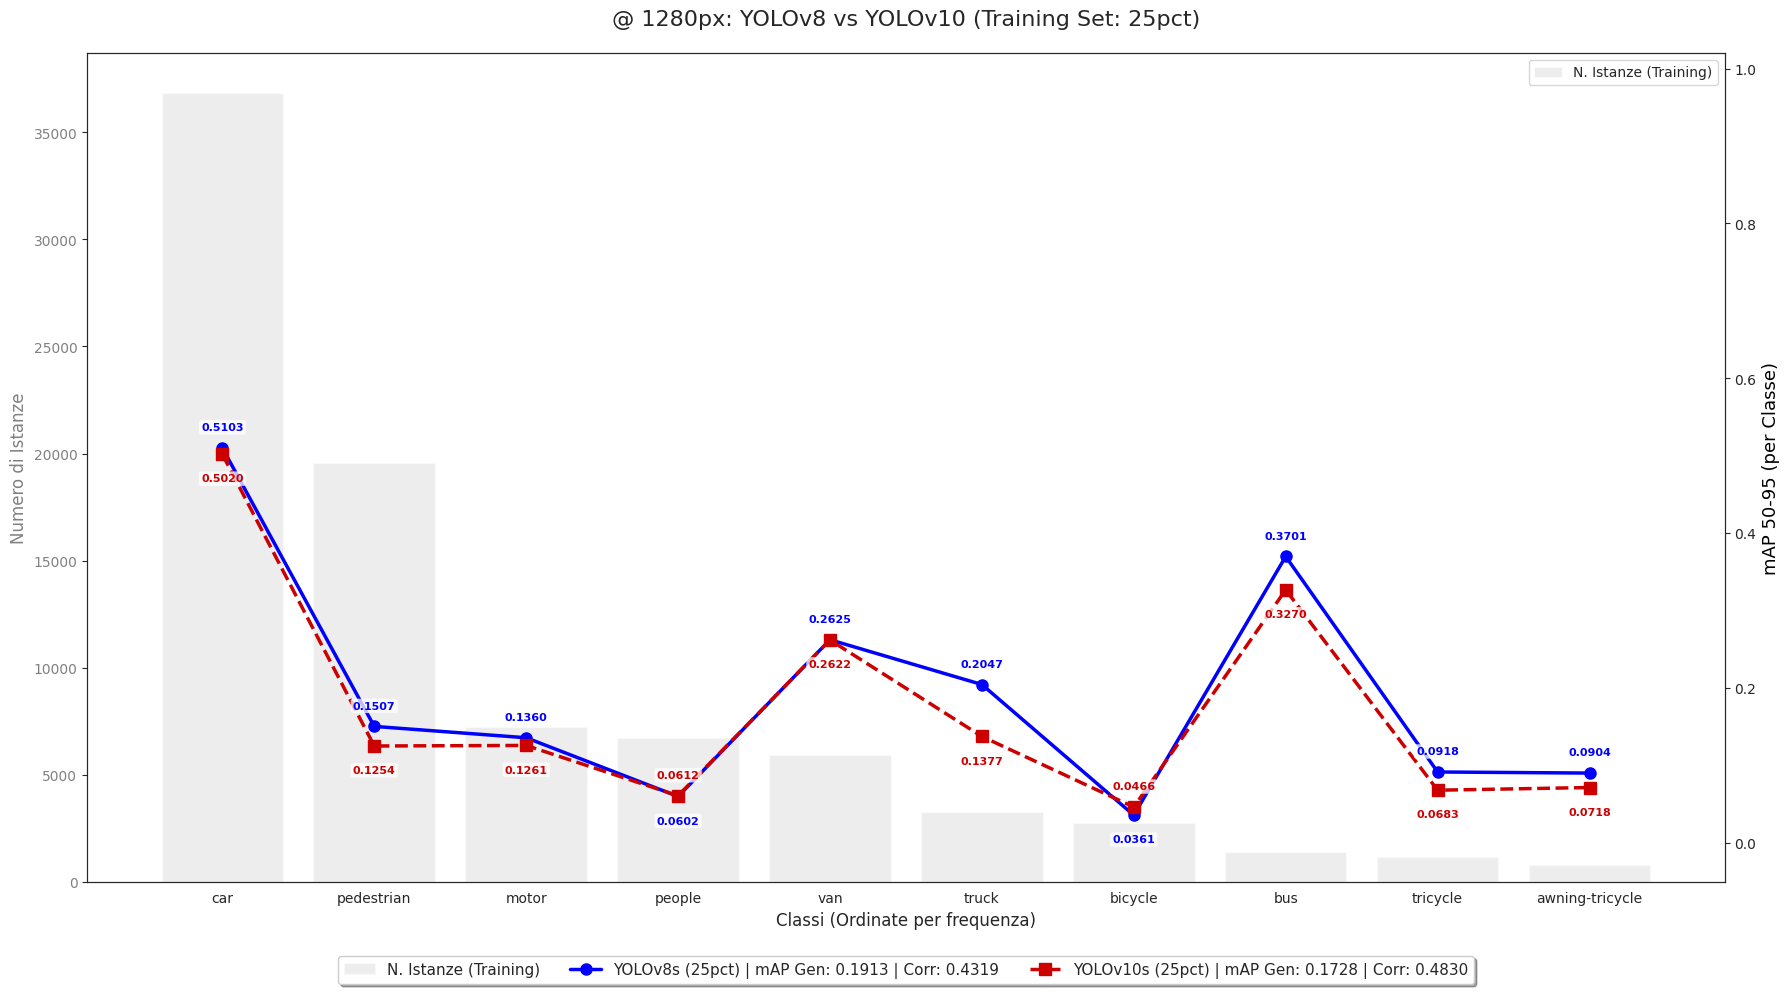

 Salvato: Grafici_Analisi_Complete_Con_Correlazione/Analisi_25pct_1280px.png


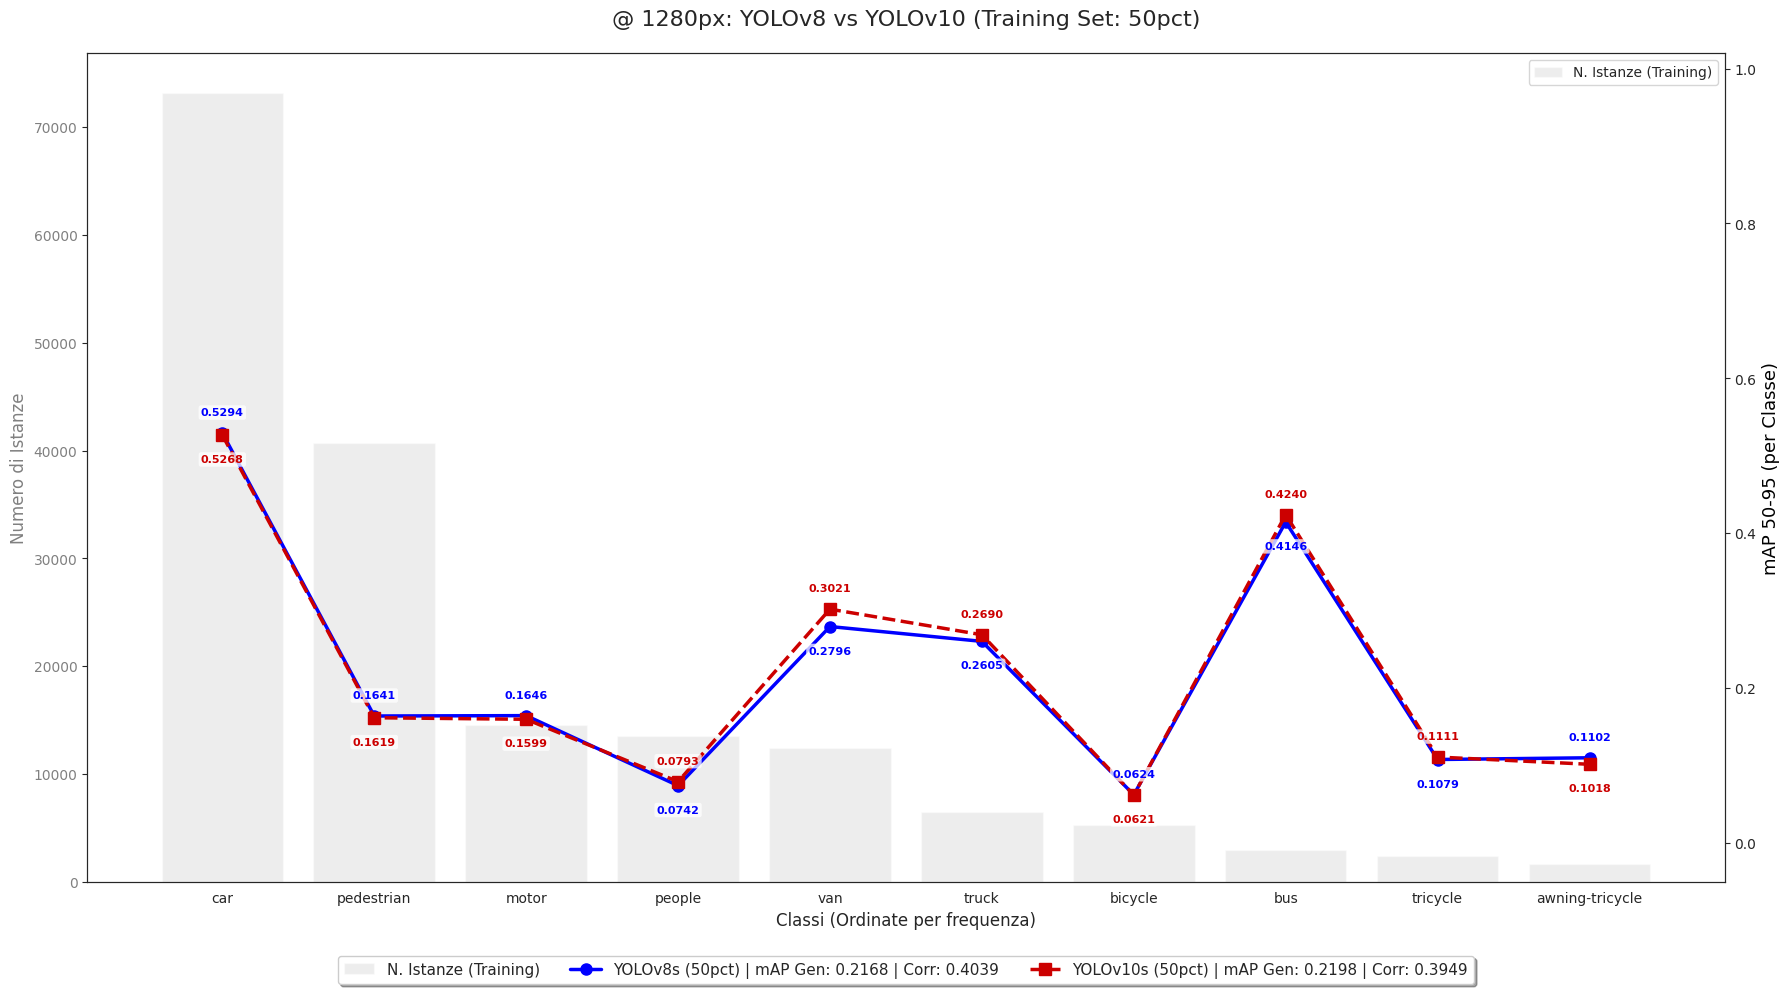

 Salvato: Grafici_Analisi_Complete_Con_Correlazione/Analisi_50pct_1280px.png


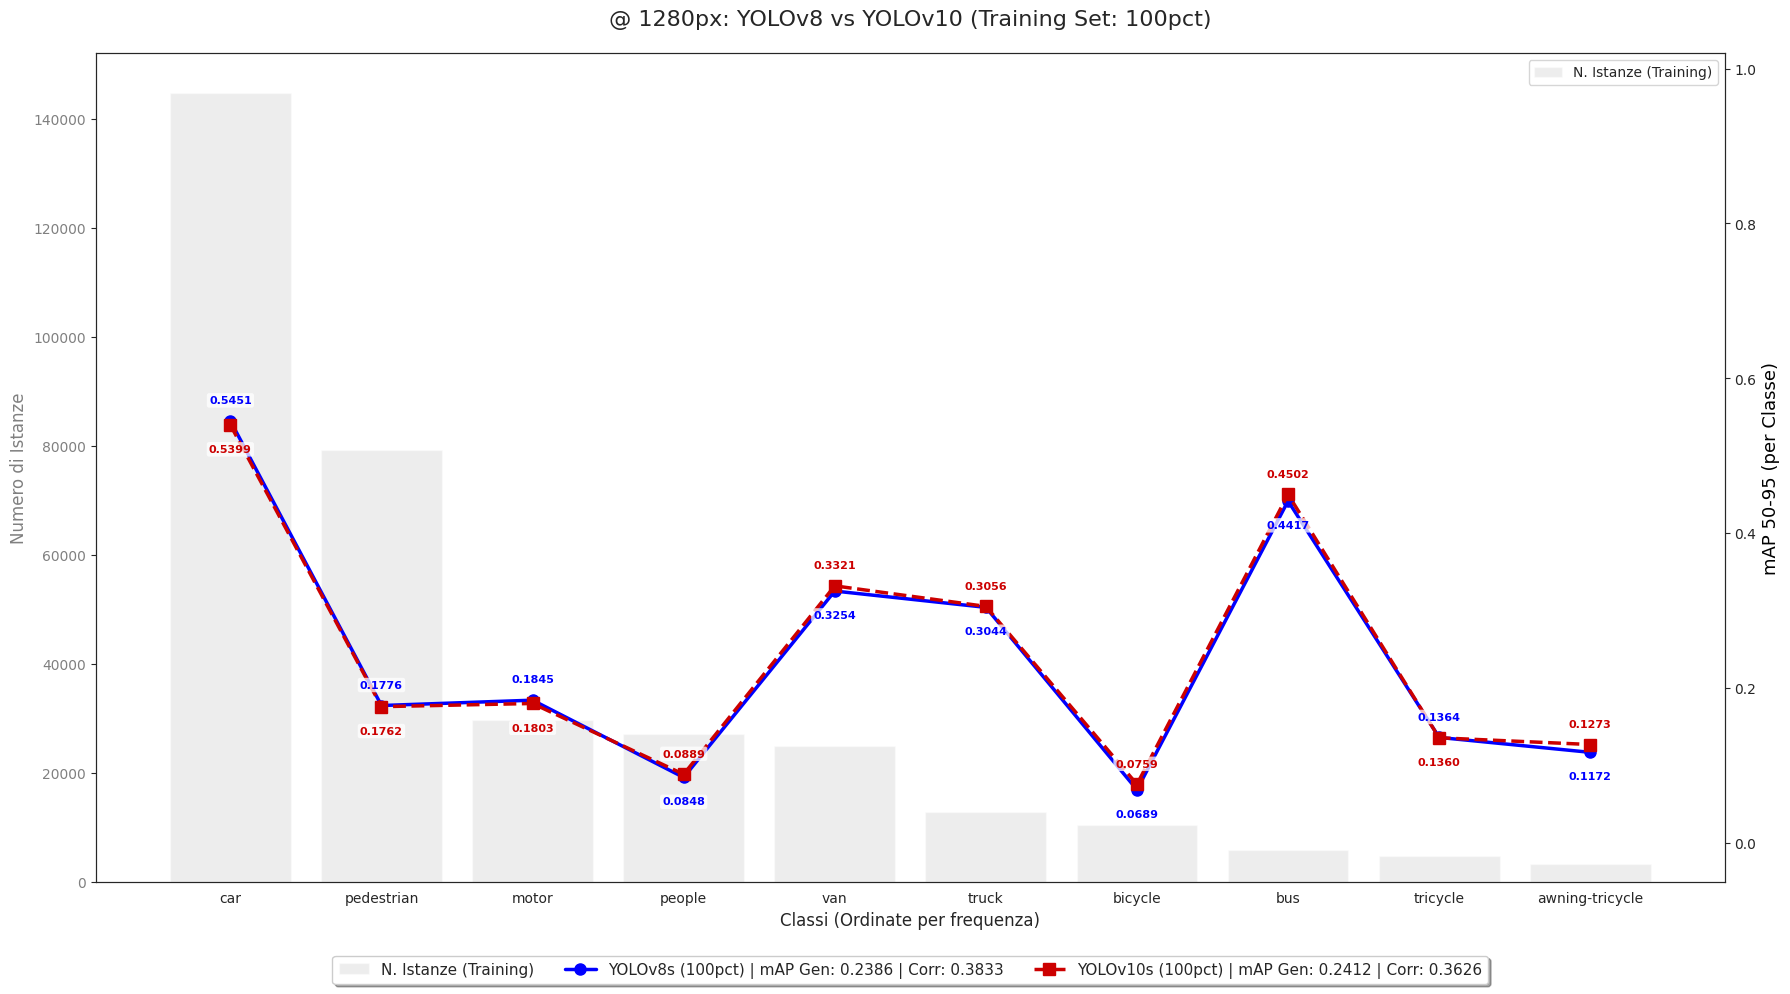

 Salvato: Grafici_Analisi_Complete_Con_Correlazione/Analisi_100pct_1280px.png

 Elaborazione: 1600 px...


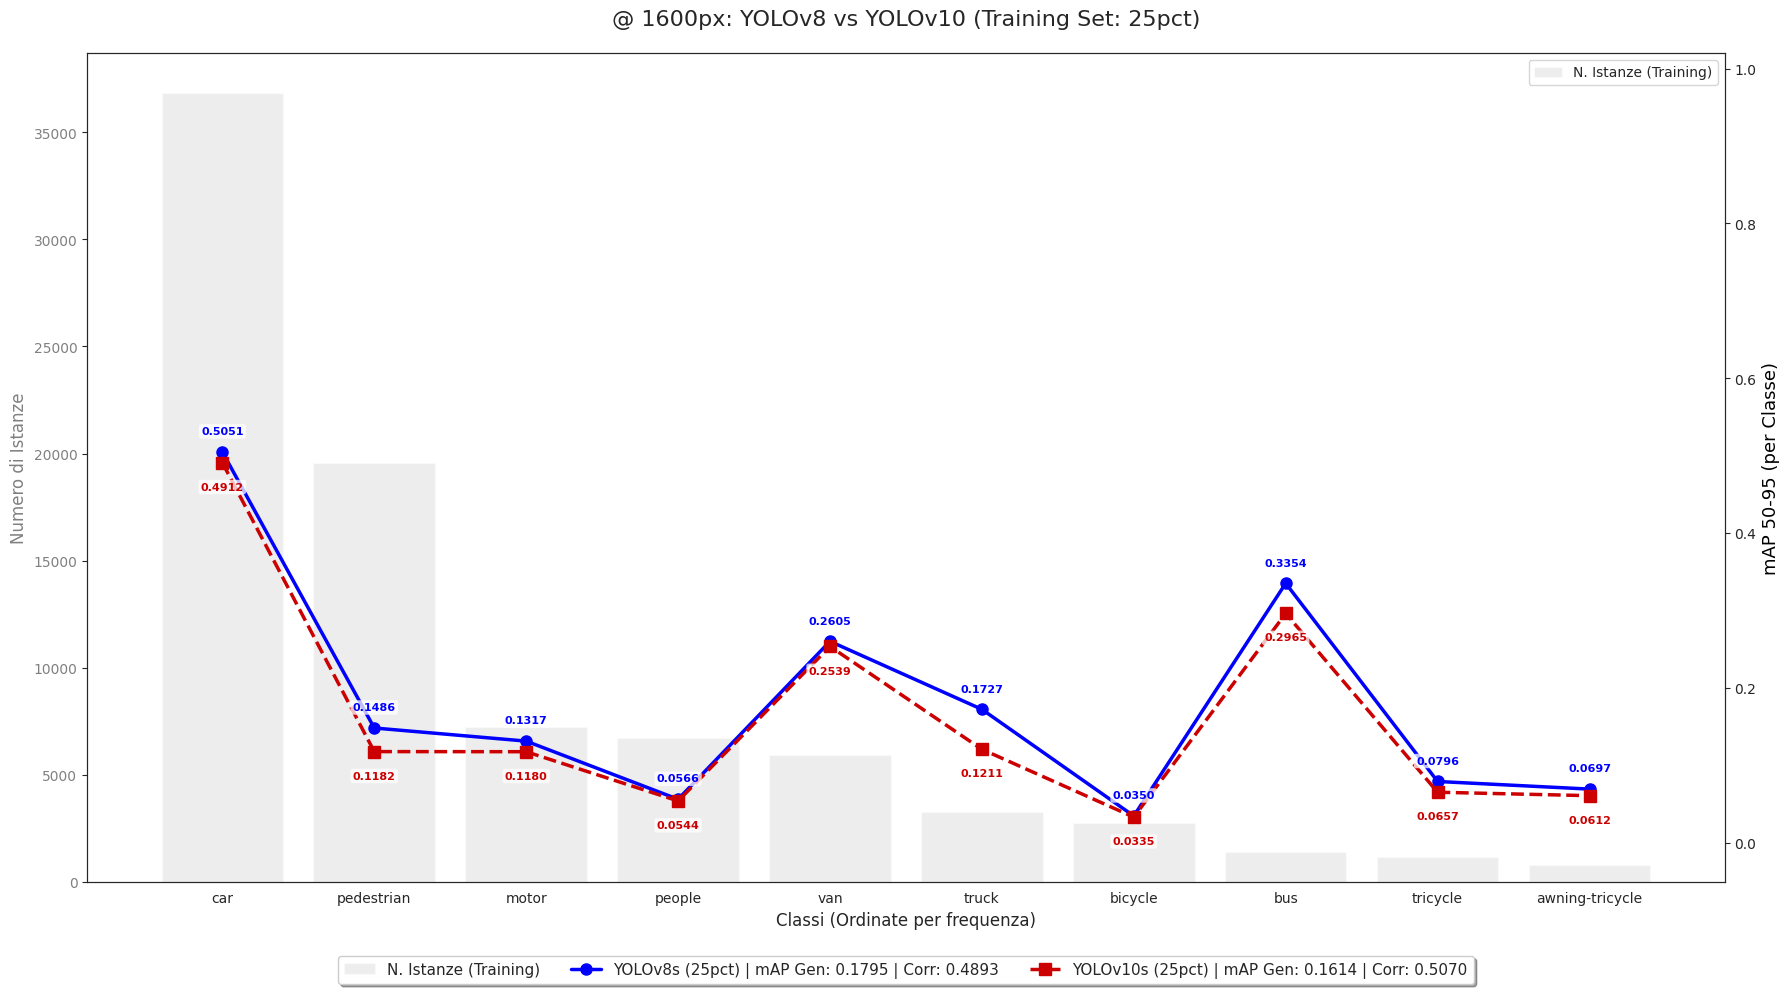

 Salvato: Grafici_Analisi_Complete_Con_Correlazione/Analisi_25pct_1600px.png


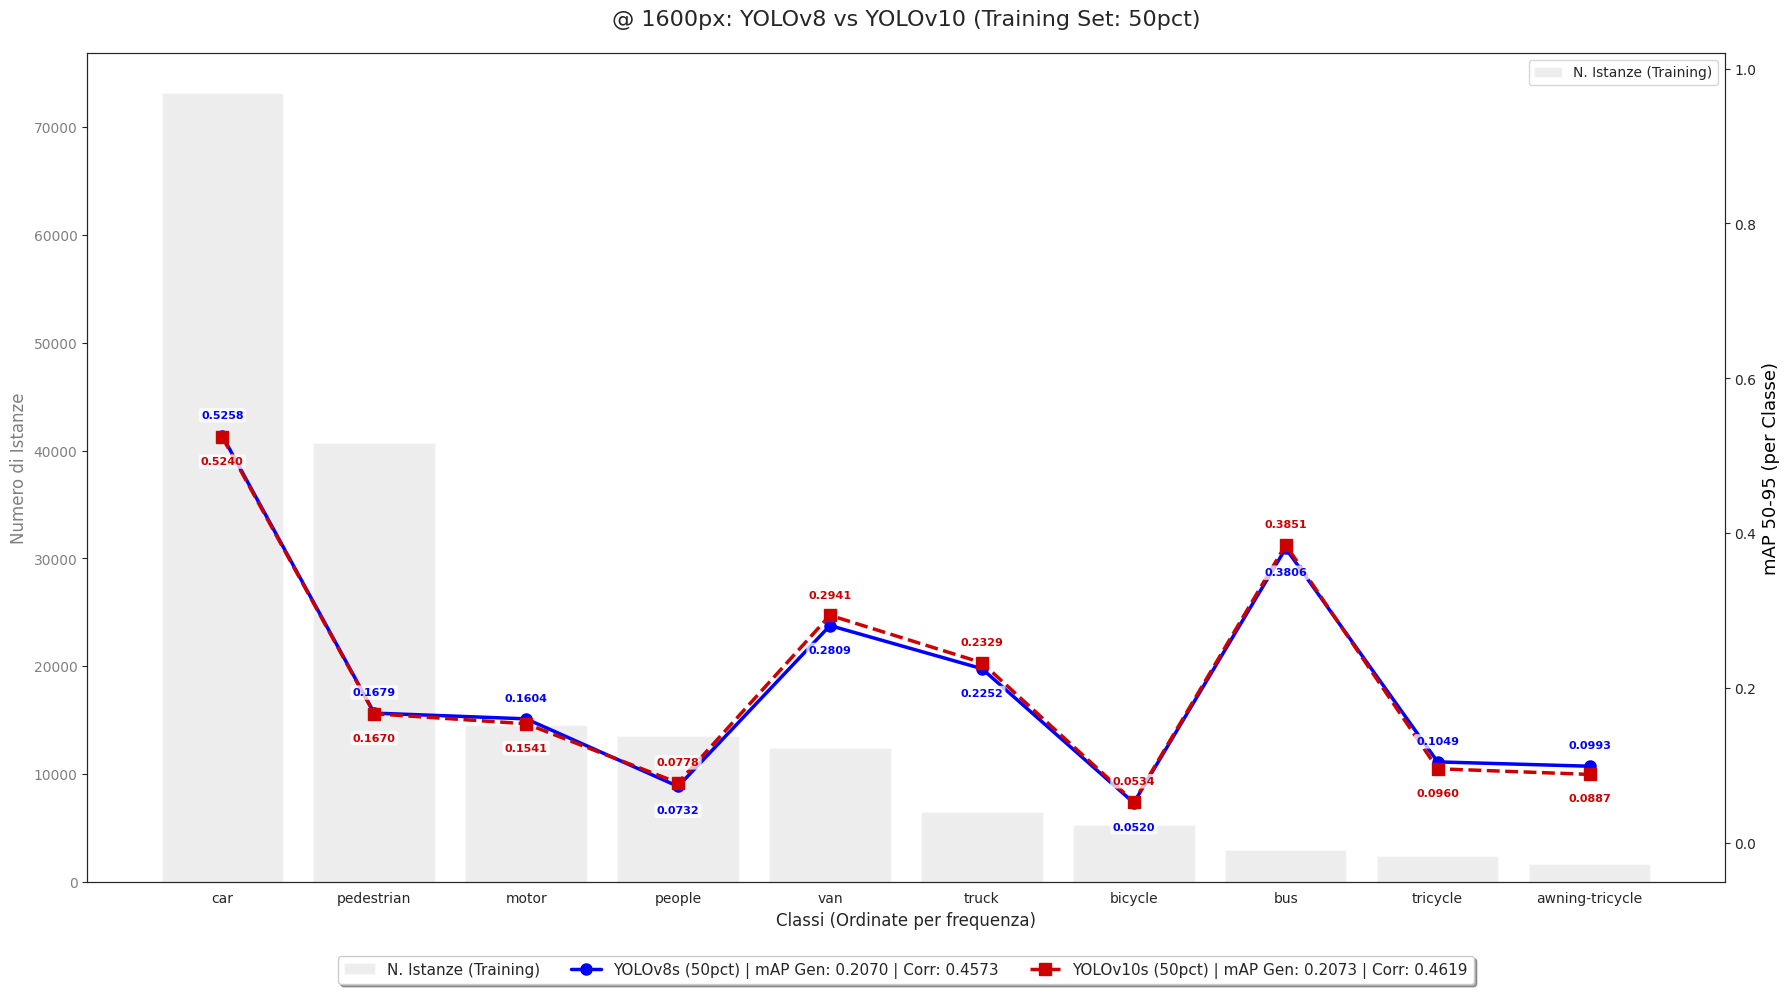

 Salvato: Grafici_Analisi_Complete_Con_Correlazione/Analisi_50pct_1600px.png


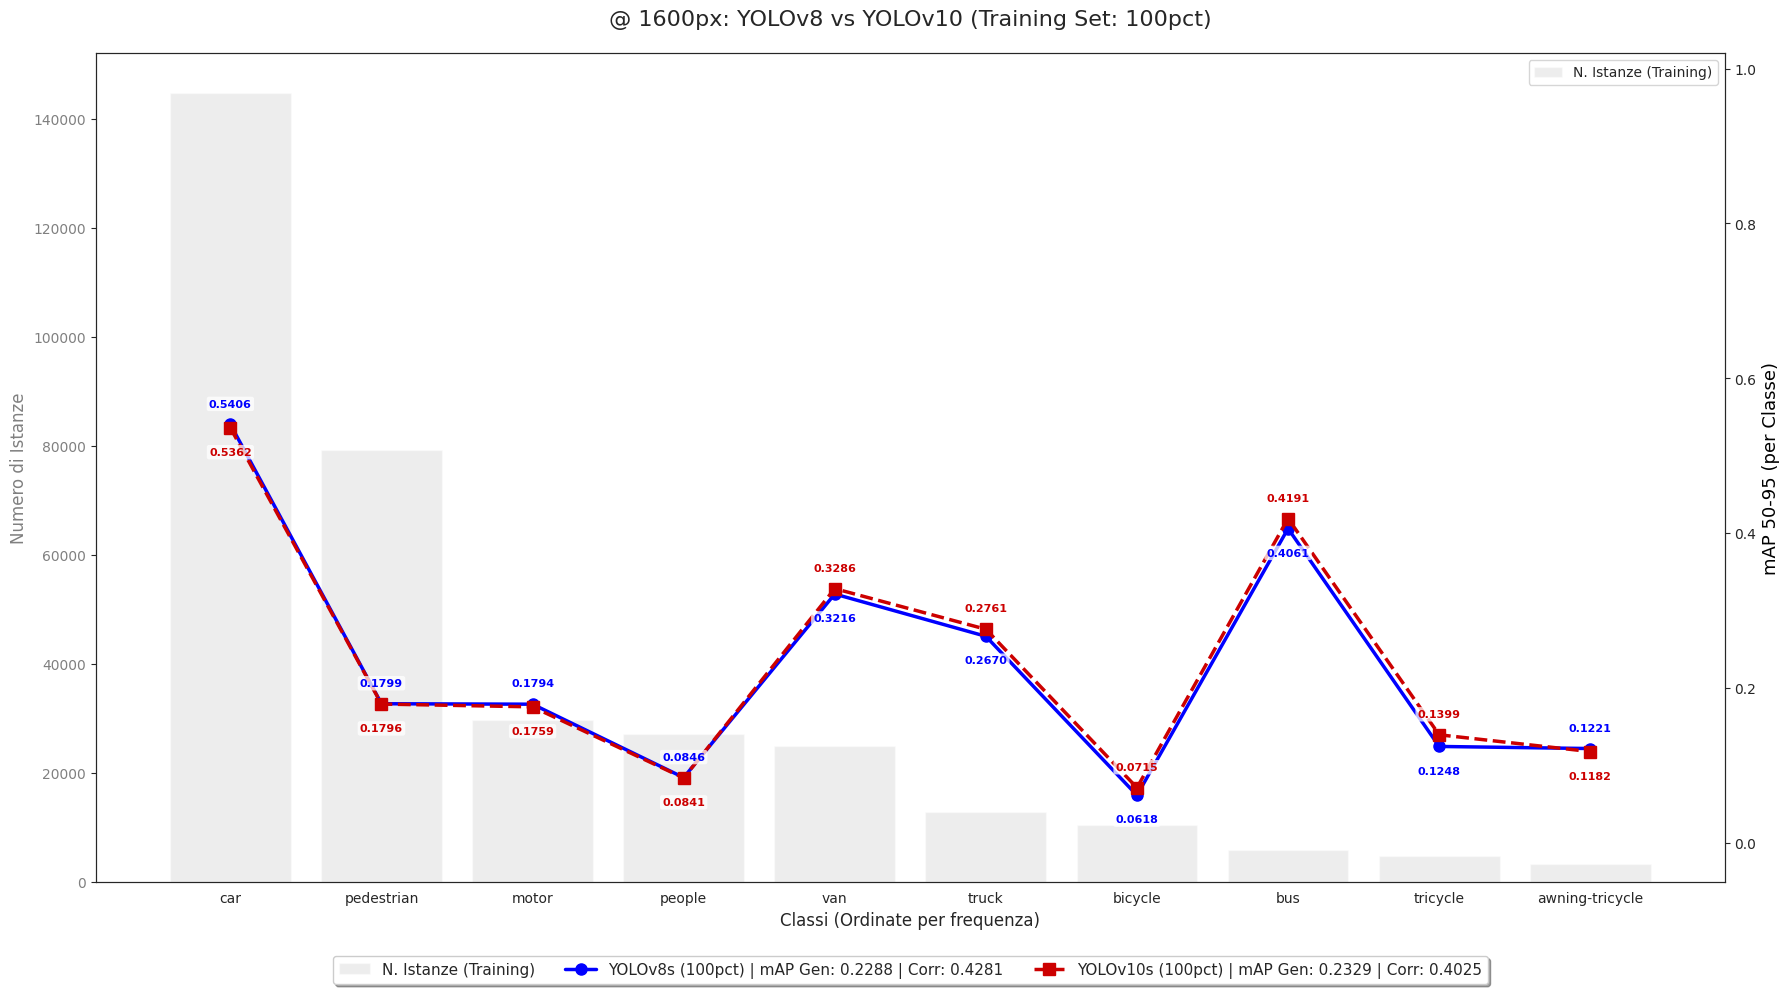

 Salvato: Grafici_Analisi_Complete_Con_Correlazione/Analisi_100pct_1600px.png


/kaggle/working/Grafici_Finali_Completi_Con_Corr.zip

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import shutil
import os
from IPython.display import FileLink

# Load data
df_results = pd.read_csv('/kaggle/input/results/Risultati_Completi_Classi.csv') 
df_dist = pd.read_csv('/kaggle/input/results/Distribuzione_Classi_Splits.csv')      

# Output folder
output_dir = "Grafici_Analisi_Complete_Con_Correlazione"
if os.path.exists(output_dir):
    shutil.rmtree(output_dir)
os.makedirs(output_dir, exist_ok=True)

# Find resolution
unique_imgsz = sorted(df_results['ImgSz'].unique())

# Configuration
splits = ['25pct', '50pct', '100pct']
suffix_map = {'25pct': '_25', '50pct': '_50', '100pct': '_100'}

sns.set_style("white") 
bbox_props = dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=0.75)


# Generation loop

for current_imgsz in unique_imgsz:
    print(f"\n Elaborazione: {current_imgsz} px...")
    
    df_res_filtered = df_results[df_results['ImgSz'] == current_imgsz].copy()
    
    for split in splits:
        split_suffix = suffix_map[split]
        
        # Data distribution
        dist_data = df_dist[['Class_Name', split]].sort_values(by=split, ascending=False)
        ordered_classes = dist_data['Class_Name'].tolist()
        counts = dist_data[split].values
        
        # mAp data and models
        model_v8_name = f"YOLOv8s{split_suffix}"
        model_v10_name = f"YOLOv10s{split_suffix}"
        
        row_v8 = df_res_filtered[df_res_filtered['Modello'] == model_v8_name]
        row_v10 = df_res_filtered[df_res_filtered['Modello'] == model_v10_name]
        
        # Fallback naming
        if row_v8.empty:
             row_v8 = df_res_filtered[df_res_filtered['Modello'] == f"{model_v8_name}_{current_imgsz}"]
        if row_v10.empty:
             row_v10 = df_res_filtered[df_res_filtered['Modello'] == f"{model_v10_name}_{current_imgsz}"]

        if row_v8.empty or row_v10.empty:
            print(f" Dati mancanti per {split}. Salto.")
            continue

        # Data extraction
        # 1. Total mAP 
        map_total_v8 = row_v8['mAP50-95'].values[0]
        map_total_v10 = row_v10['mAP50-95'].values[0]

        # 2. mAP for class
        map_v8 = []
        map_v10 = []
        for cls in ordered_classes:
            col_name = f"{cls}_mAP50-95"
            val8 = row_v8[col_name].values[0] if col_name in row_v8.columns else 0
            val10 = row_v10[col_name].values[0] if col_name in row_v10.columns else 0
            map_v8.append(val8)
            map_v10.append(val10)

        # --- 3. CALCOLO CORRELAZIONE (NUOVO STEP) ---
        # Correlazione tra log(Istanze) e mAP per classe
        corr_v8 = np.corrcoef(np.log1p(counts), map_v8)[0, 1]
        corr_v10 = np.corrcoef(np.log1p(counts), map_v10)[0, 1]

        # Plot
        fig, ax1 = plt.subplots(figsize=(18, 10))
        
        # Histogram Instances (Left axis)
        bars = sns.barplot(x=ordered_classes, y=counts, color='lightgray', alpha=0.4, ax=ax1, label='N. Istanze (Training)')
        ax1.set_ylabel('Numero di Istanze', fontsize=12, color='gray')
        ax1.set_xlabel('Classi (Ordinate per frequenza)', fontsize=12)
        ax1.tick_params(axis='y', labelcolor='gray')
        ax1.grid(False) 

        # B. mAP lines (Right axis)
        ax2 = ax1.twinx()
        
        # Label creation with total mAP AND Correlation included
        label_v8 = f'YOLOv8s ({split}) | mAP Gen: {map_total_v8:.4f} | Corr: {corr_v8:.4f}'
        label_v10 = f'YOLOv10s ({split}) | mAP Gen: {map_total_v10:.4f} | Corr: {corr_v10:.4f}'
        
        # Plot Lines
        ax2.plot(ordered_classes, map_v8, marker='o', color='blue', linewidth=2.5, markersize=8, label=label_v8)
        ax2.plot(ordered_classes, map_v10, marker='s', color='#cc0000', linewidth=2.5, markersize=8, linestyle='--', label=label_v10)
        
        # Point Value Notes
        for i in range(len(ordered_classes)):
            v8 = map_v8[i]
            v10 = map_v10[i]
            
            # Logic to avoid overlaps
            if v8 >= v10:
                ax2.text(i, v8 + 0.02, f"{v8:.4f}", color='blue', ha='center', va='bottom', 
                         fontsize=8, fontweight='bold', bbox=bbox_props)
                ax2.text(i, v10 - 0.025, f"{v10:.4f}", color='#cc0000', ha='center', va='top', 
                         fontsize=8, fontweight='bold', bbox=bbox_props)
            else:
                ax2.text(i, v10 + 0.02, f"{v10:.4f}", color='#cc0000', ha='center', va='bottom', 
                         fontsize=8, fontweight='bold', bbox=bbox_props)
                ax2.text(i, v8 - 0.025, f"{v8:.4f}", color='blue', ha='center', va='top', 
                         fontsize=8, fontweight='bold', bbox=bbox_props)

        ax2.set_ylabel('mAP 50-95 (per Classe)', fontsize=13, color='black')
        ax2.set_ylim(-0.05, 1.02) 
        
        # Title
        plt.title(f'@ {current_imgsz}px: YOLOv8 vs YOLOv10 (Training Set: {split})', fontsize=16, pad=20)
        
        # Unified Legend (Bars + Lines)
        lines_1, labels_1 = ax1.get_legend_handles_labels()
        lines_2, labels_2 = ax2.get_legend_handles_labels()
        # Position legend below the graph
        ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper center', bbox_to_anchor=(0.5, -0.08), ncol=3, fontsize=11, frameon=True, shadow=True)
        
        plt.tight_layout()
        
        filename = f"{output_dir}/Analisi_{split}_{current_imgsz}px.png"
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        
        plt.show() 
        print(f" Salvato: {filename}")

# Zip and download
shutil.make_archive('Grafici_Finali_Completi_Con_Corr', 'zip', output_dir)

display(FileLink('Grafici_Finali_Completi_Con_Corr.zip'))

 Risoluzioni di test trovate: [np.int64(640), np.int64(1024), np.int64(1280), np.int64(1600)]

  Generazione confronto @ TEST SIZE: 640 px...


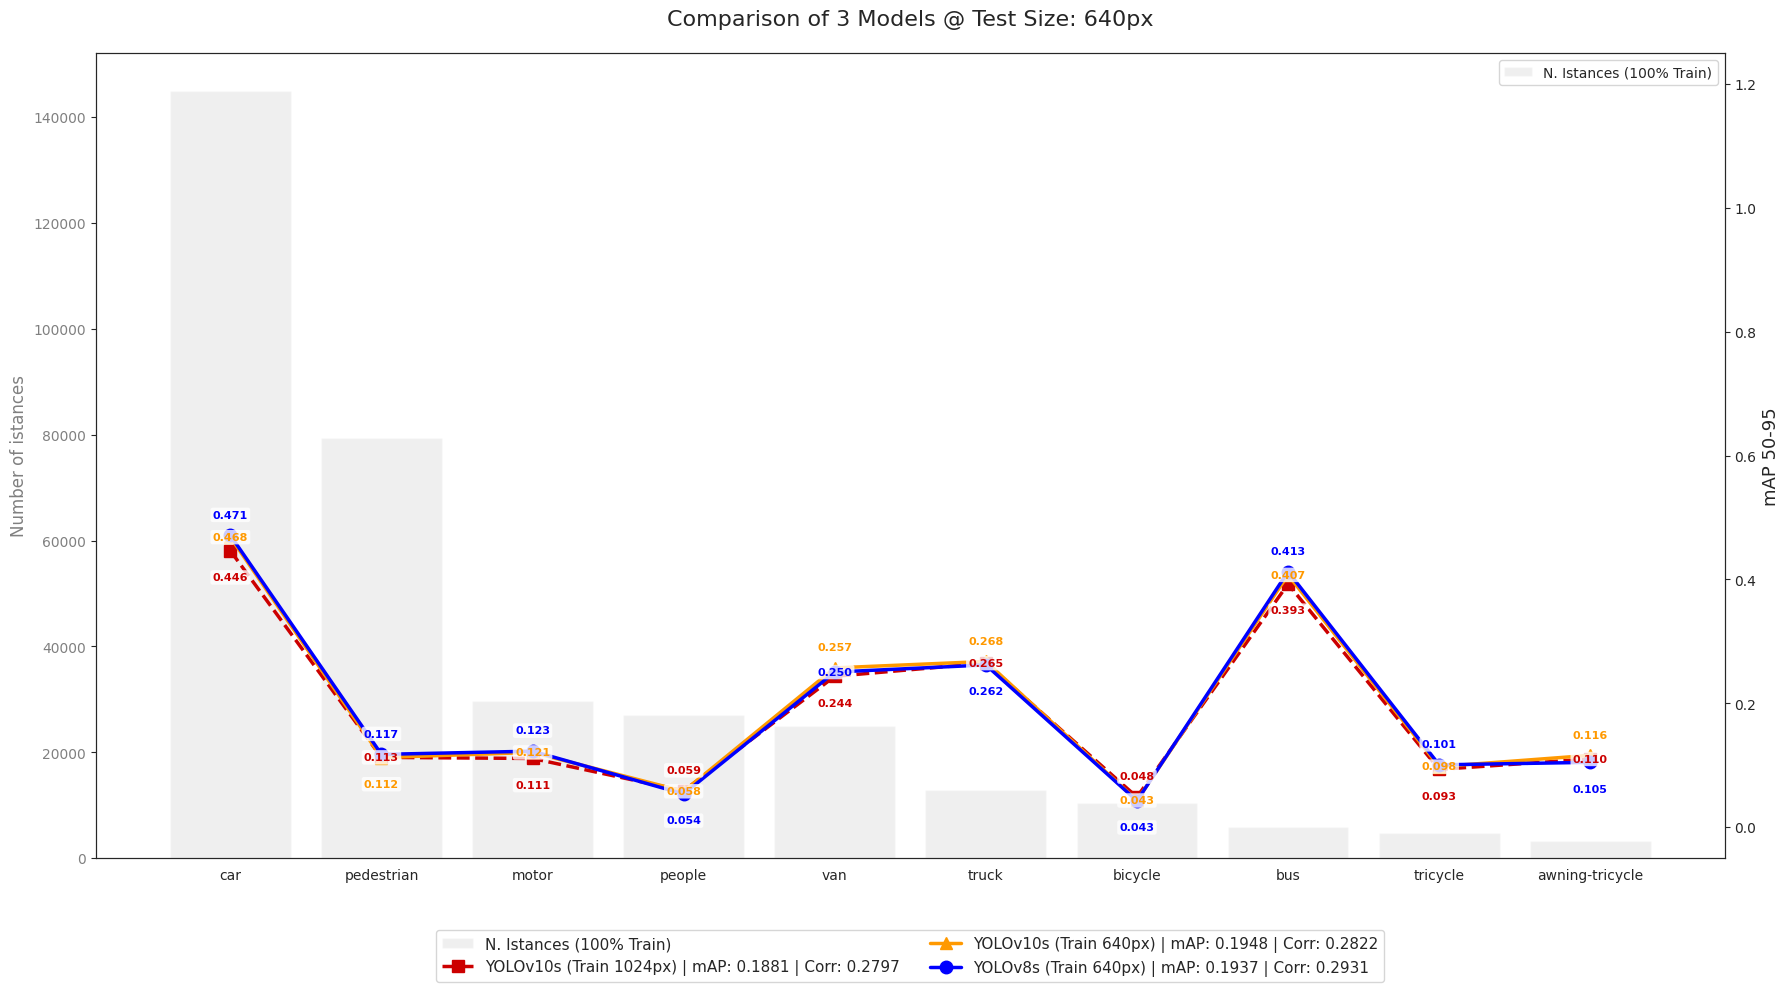


  Generazione confronto @ TEST SIZE: 1024 px...


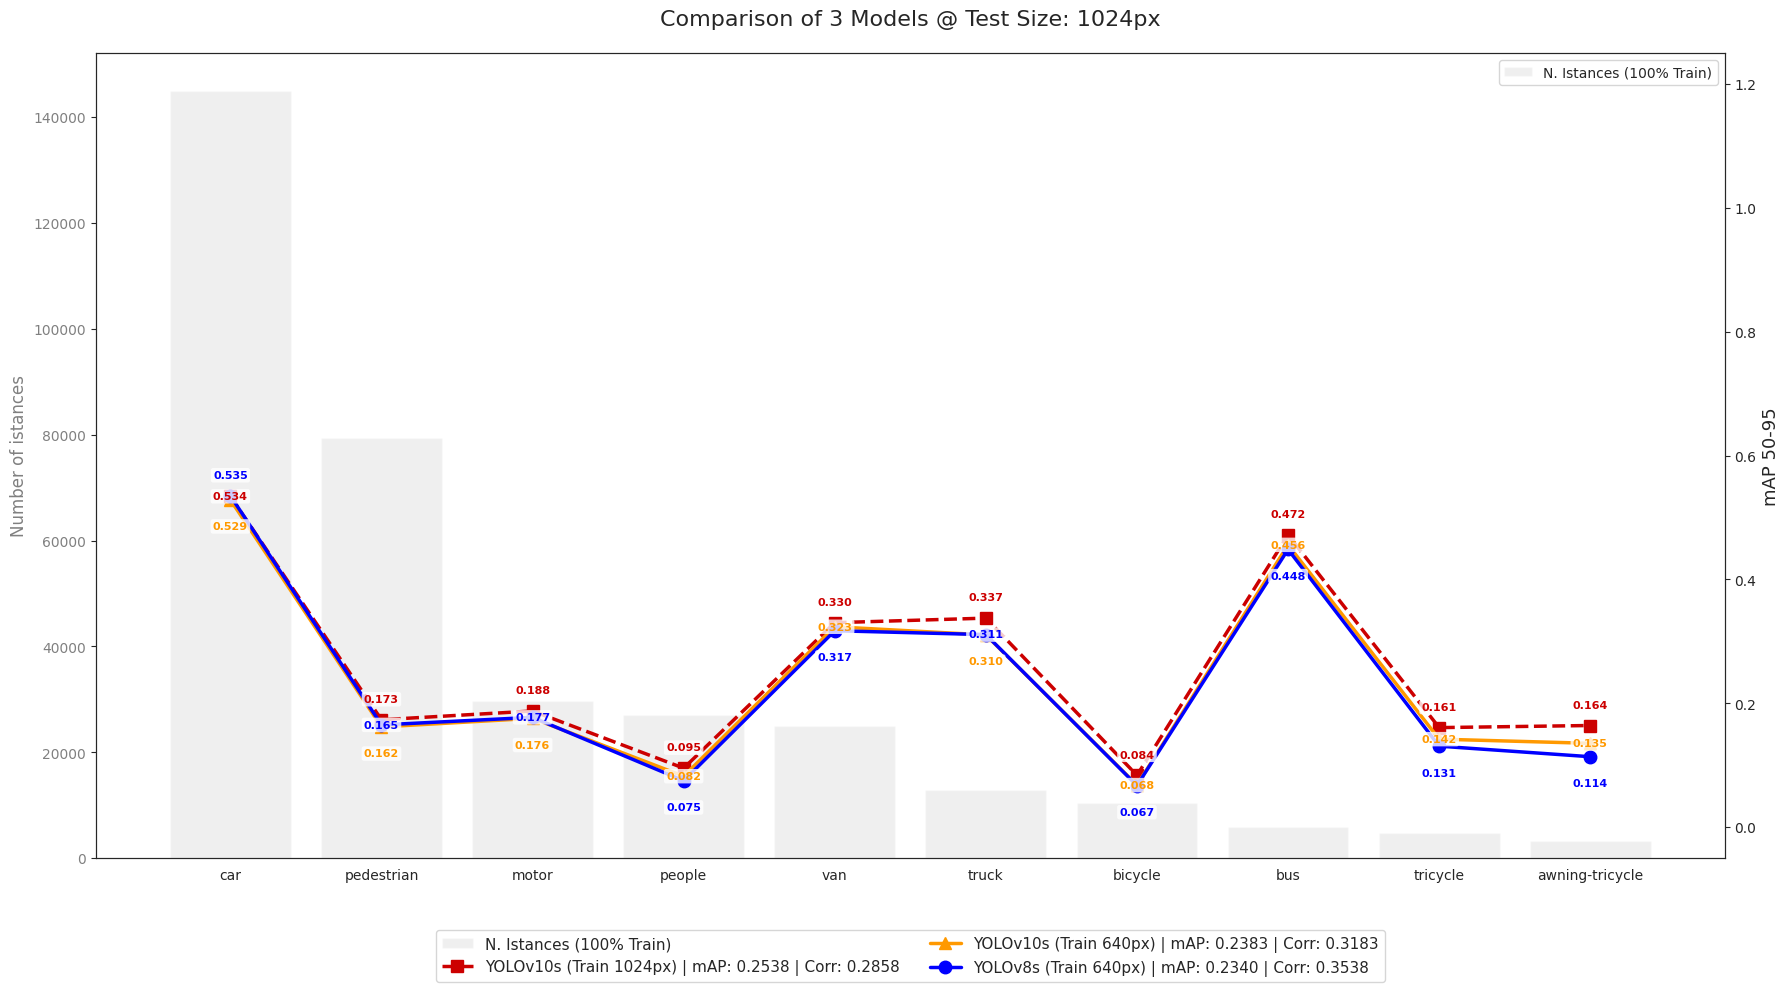


  Generazione confronto @ TEST SIZE: 1280 px...


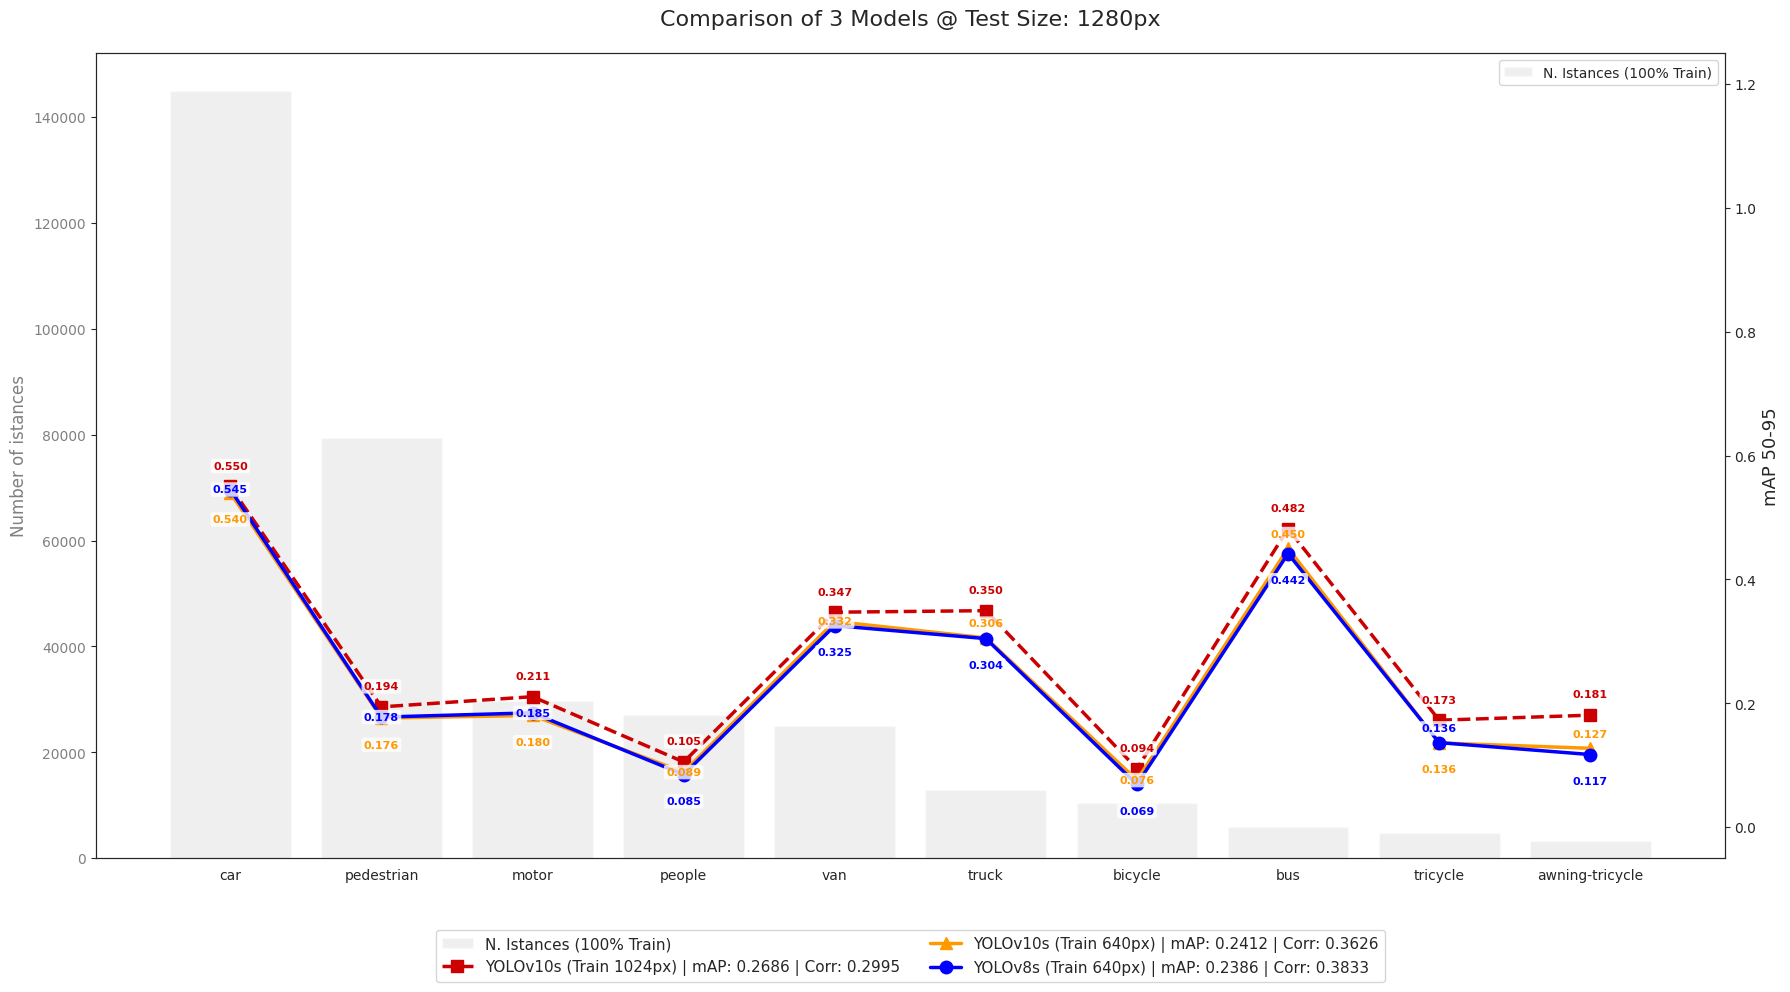


  Generazione confronto @ TEST SIZE: 1600 px...


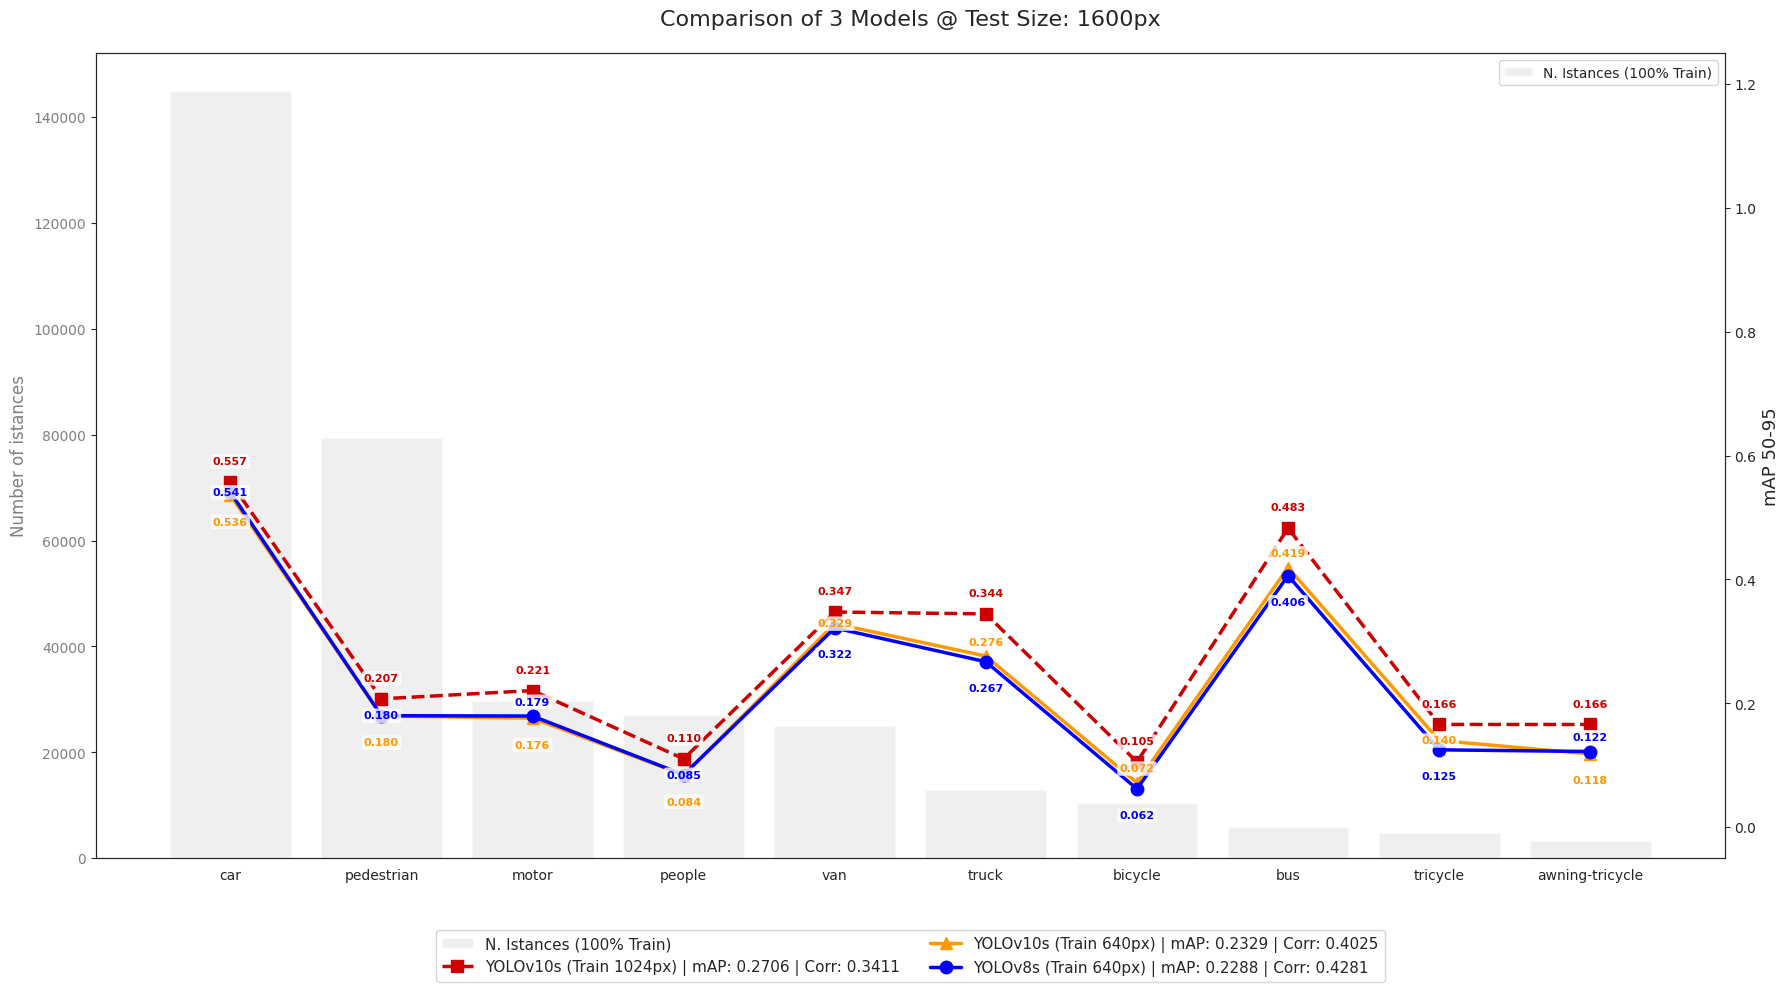

/kaggle/working/Grafici_Confronto_3Modelli_MultiScala.zip

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import shutil
import os
from IPython.display import FileLink

# Load and setup 
df_results = pd.read_csv('/kaggle/input/results/Risultati_Completi_Classi.csv') 
df_dist = pd.read_csv('/kaggle/input/results/Distribuzione_Classi_Splits.csv')      

output_dir = "Grafici_Confronto_3Modelli_MultiScala"
if os.path.exists(output_dir):
    shutil.rmtree(output_dir)
os.makedirs(output_dir, exist_ok=True)

# Find all test resolutions available in csv
unique_test_resolutions = sorted(df_results['ImgSz'].unique())
print(f" Risoluzioni di test trovate: {unique_test_resolutions}")

# Definition of the 3 target models
models_to_compare = [
    {
        "label": "YOLOv10s (Train 1024px)",
        "model_name": "YOLOv10s_100_1024",
        "color": "#cc0000", # Rosso Scuro
        "marker": "s",
        "style": "--"
    },
    {
        "label": "YOLOv10s (Train 640px)",
        "model_name": "YOLOv10s_100",
        "color": "#ff9900", # Arancione
        "marker": "^",
        "style": "-"
    },
    {
        "label": "YOLOv8s (Train 640px)",
        "model_name": "YOLOv8s_100",
        "color": "blue",    # Blu
        "marker": "o",
        "style": "-"
    }
]

# 100% distribution (fixed base)
dist_data = df_dist[['Class_Name', '100pct']].sort_values(by='100pct', ascending=False)
ordered_classes = dist_data['Class_Name'].tolist()
counts = dist_data['100pct'].values

sns.set_style("white")
bbox_props = dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=0.8)

# Test resolution loop
for test_res in unique_test_resolutions:
    print(f"\n  Generazione confronto @ TEST SIZE: {test_res} px...")
    
    plot_data = []
    
    # Filter the dataframe for the current test resolution
    df_current_res = df_results[df_results['ImgSz'] == test_res]
    
    missing_model = False
    
    for model_cfg in models_to_compare:
        # Create a copy so as not to change the original dictionary
        t = model_cfg.copy()
        
        # Look for the specific model in the current resolution
        row = df_current_res[df_current_res['Modello'] == t['model_name']]
        
        if row.empty:
            print(f" Dato mancante: {t['model_name']} non è stato testato a {test_res}px.")
            # Handling missing data
            # If a model is missing, it is generated with zeros.
            t['data'] = [0] * len(ordered_classes)
            t['gen_map'] = 0
            t['corr'] = 0
            missing_model = True
        else:
            m_aps = []
            gen_map = row['mAP50-95'].values[0]
            for cls in ordered_classes:
                col = f"{cls}_mAP50-95"
                val = row[col].values[0] if col in row.columns else 0
                m_aps.append(val)
            
            # Correlation computing
            corr = np.corrcoef(np.log1p(counts), m_aps)[0, 1]
            
            t['data'] = m_aps
            t['gen_map'] = gen_map
            t['corr'] = corr
            
        plot_data.append(t)

    # If all models are missing, skip
    if all(t['gen_map'] == 0 for t in plot_data):
        print(" Nessun dato disponibile per questa risoluzione. Salto.")
        continue

    # Plot
    fig, ax1 = plt.subplots(figsize=(18, 10))

    # Background (Distribution)
    sns.barplot(x=ordered_classes, y=counts, color='lightgray', alpha=0.35, ax=ax1, label='N. Istances (100% Train)')
    ax1.set_ylabel('Number of istances', fontsize=12, color='gray')
    ax1.tick_params(axis='y', labelcolor='gray')
    ax1.grid(False)

    # Lines (mAP)
    ax2 = ax1.twinx()

    for t in plot_data:
        label_text = f"{t['label']} | mAP: {t['gen_map']:.4f} | Corr: {t['corr']:.4f}"
        ax2.plot(ordered_classes, t['data'], marker=t['marker'], color=t['color'], 
                 linewidth=2.5, markersize=9, linestyle=t['style'], label=label_text)

    # Annotations
    for i in range(len(ordered_classes)):
        vals = [(t['data'][i], t_idx) for t_idx, t in enumerate(plot_data)]
        vals_sorted = sorted(vals, key=lambda x: x[0], reverse=True)
        
        v_high, idx_high = vals_sorted[0]
        v_mid, idx_mid = vals_sorted[1]
        v_low, idx_low = vals_sorted[2]
        
        offset_high = 0.025
        offset_low = -0.035
        offset_mid = 0.0
        
        if (v_high - v_mid) < 0.03: offset_mid -= 0.015
        if (v_mid - v_low) < 0.03:  offset_mid += 0.015
            
        # Draw High
        t = plot_data[idx_high]
        ax2.text(i, v_high + offset_high, f"{v_high:.3f}", color=t['color'], 
                 ha='center', va='bottom', fontsize=8, fontweight='bold', bbox=bbox_props)
        # Draw Mid
        t = plot_data[idx_mid]
        va_mid = 'center'
        if offset_mid > 0: va_mid = 'bottom'
        if offset_mid < 0: va_mid = 'top'
        ax2.text(i, v_mid + offset_mid, f"{v_mid:.3f}", color=t['color'], 
                 ha='center', va=va_mid, fontsize=8, fontweight='bold', bbox=bbox_props)
        # Draw Low
        t = plot_data[idx_low]
        ax2.text(i, v_low + offset_low, f"{v_low:.3f}", color=t['color'], 
                 ha='center', va='top', fontsize=8, fontweight='bold', bbox=bbox_props)

    ax2.set_ylabel('mAP 50-95', fontsize=13)
    ax2.set_ylim(-0.05, 1.25)
    
    plt.title(f'Comparison of 3 Models @ Test Size: {test_res}px', fontsize=16, pad=20)

    # Legend
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper center', bbox_to_anchor=(0.5, -0.08), ncol=2, fontsize=11)

    plt.tight_layout()

    filename = f"{output_dir}/Confronto_3Modelli_Test{test_res}.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

shutil.make_archive('Grafici_Confronto_3Modelli_MultiScala', 'zip', output_dir)
display(FileLink('Grafici_Confronto_3Modelli_MultiScala.zip'))

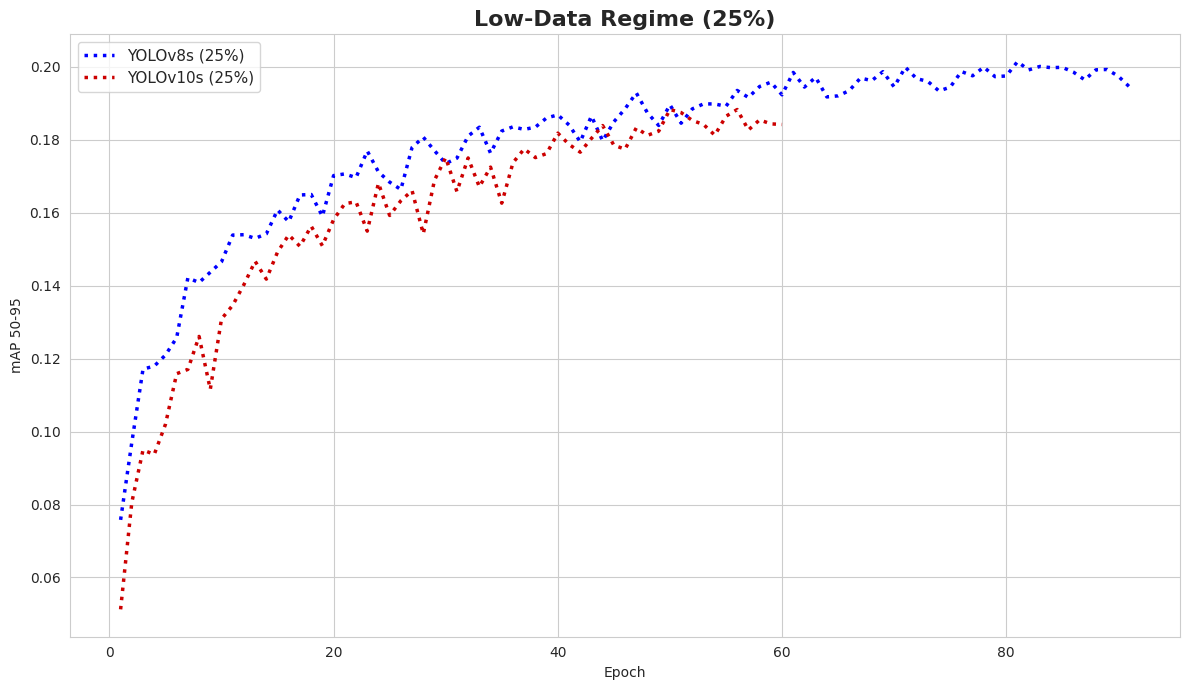

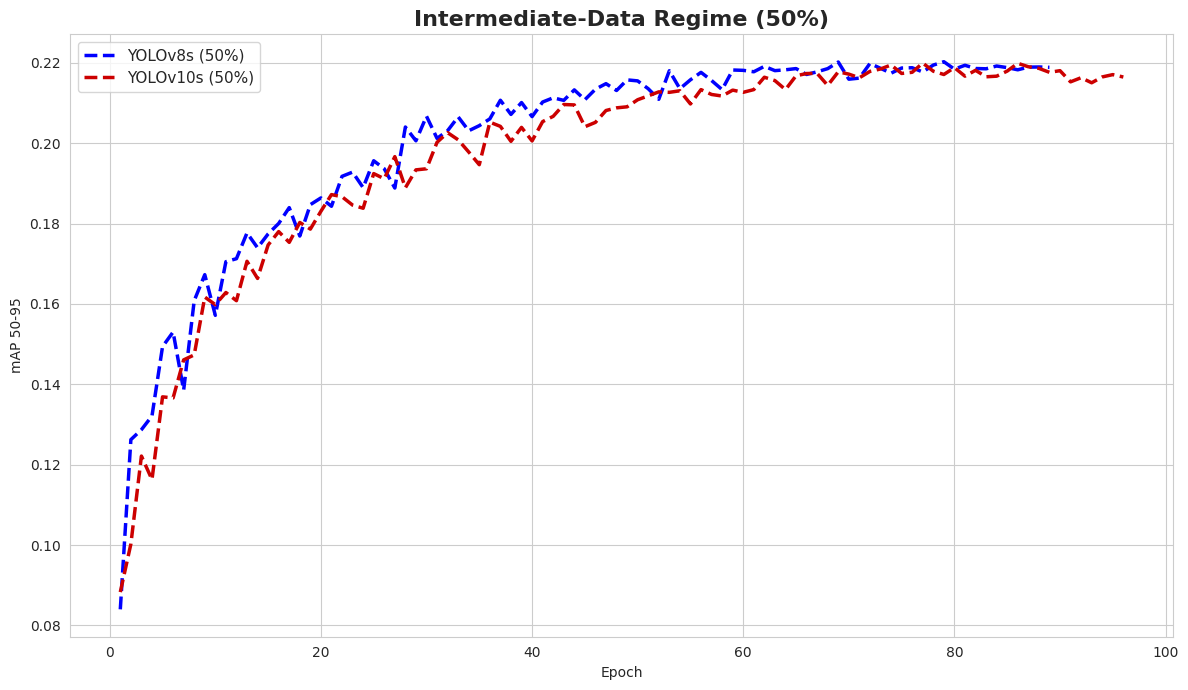

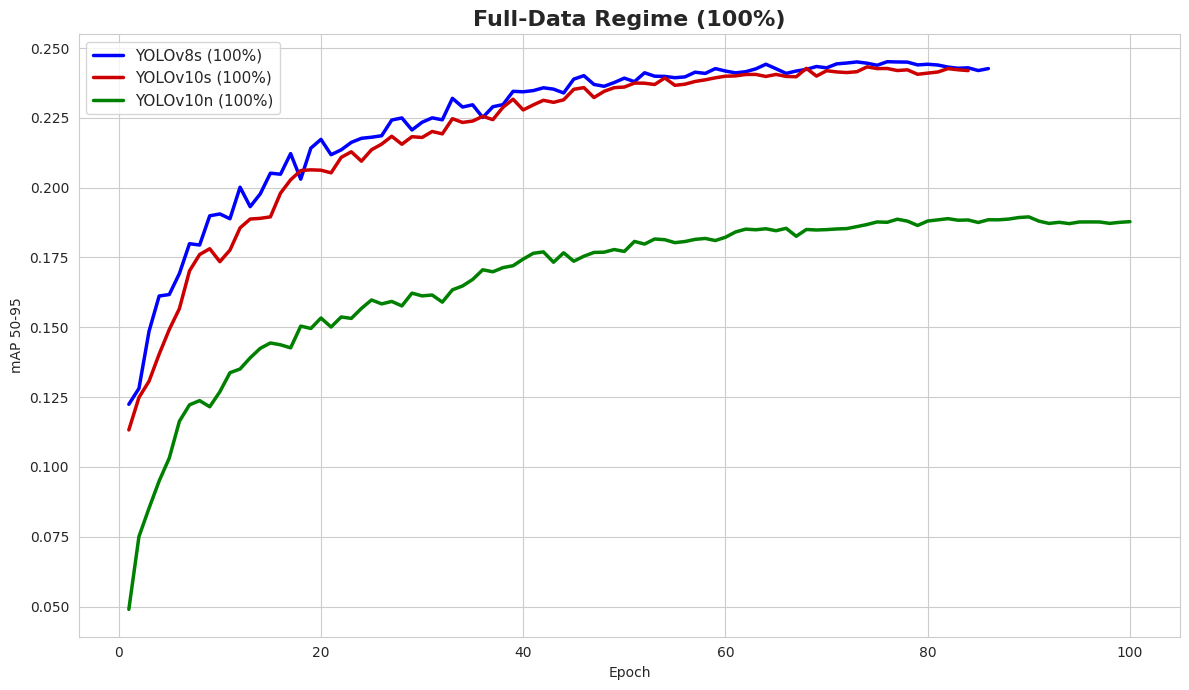


 2. Data Efficiency: YOLOv10s vs YOLOv8s vs YOLOv10n


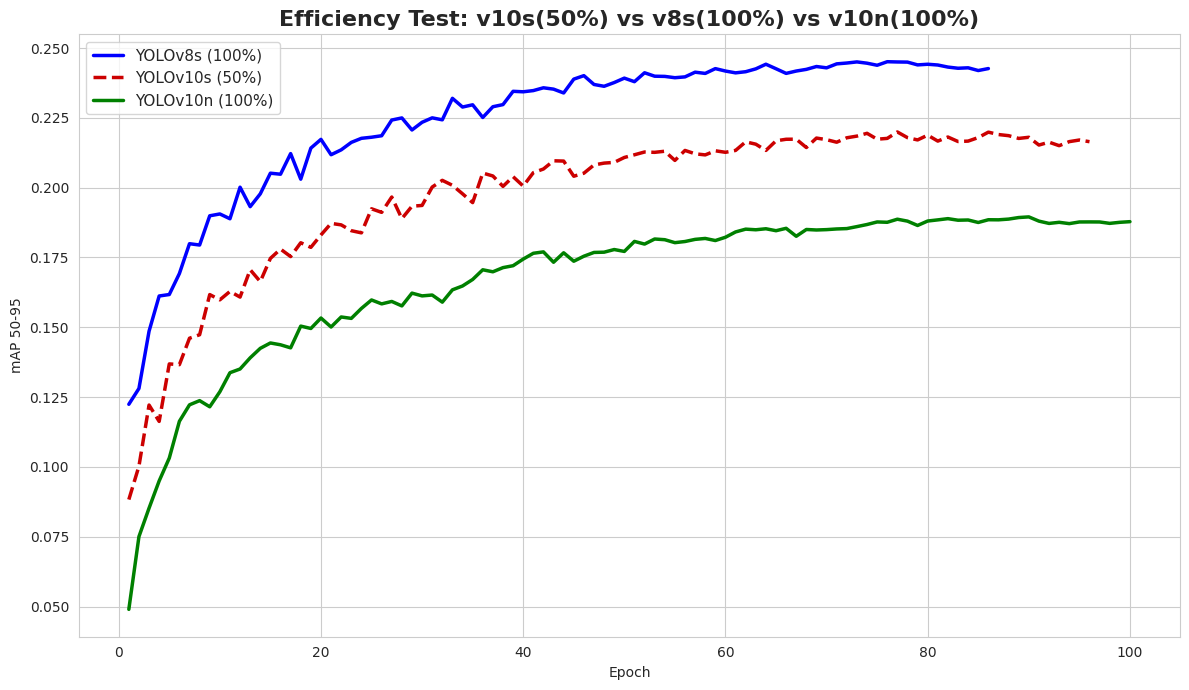


 3. Convergence Speed (First 30 Epochs @ 100% Data)


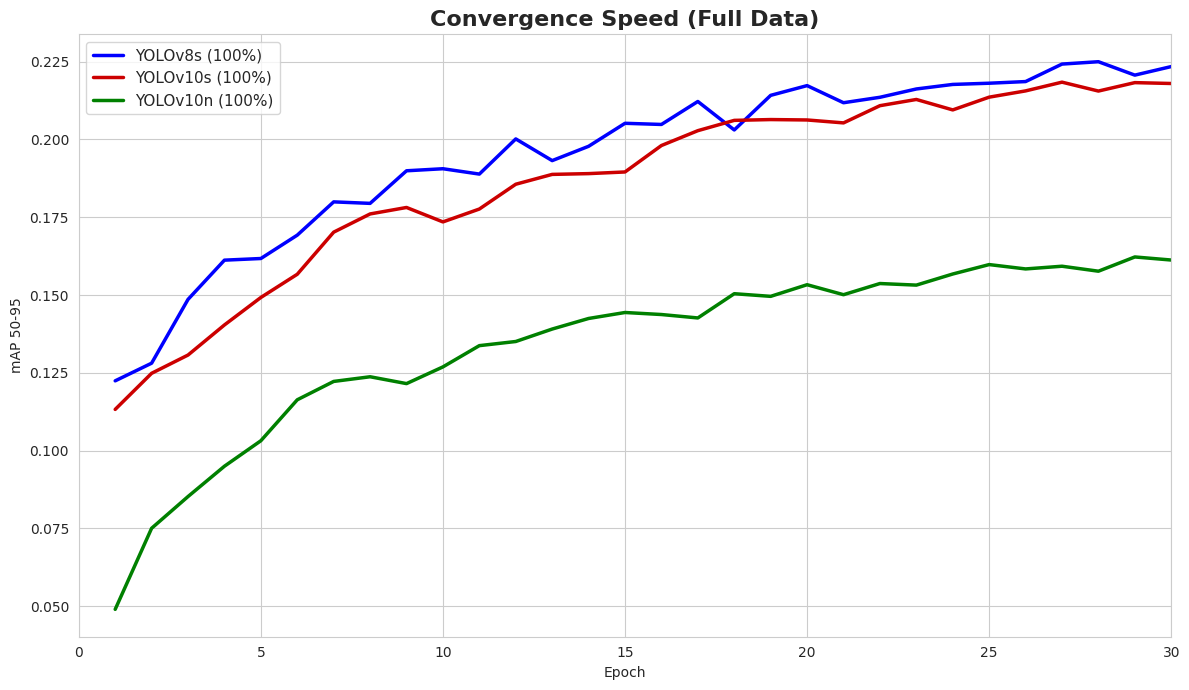


 4. Nano_10 100% vs Small_8 50%


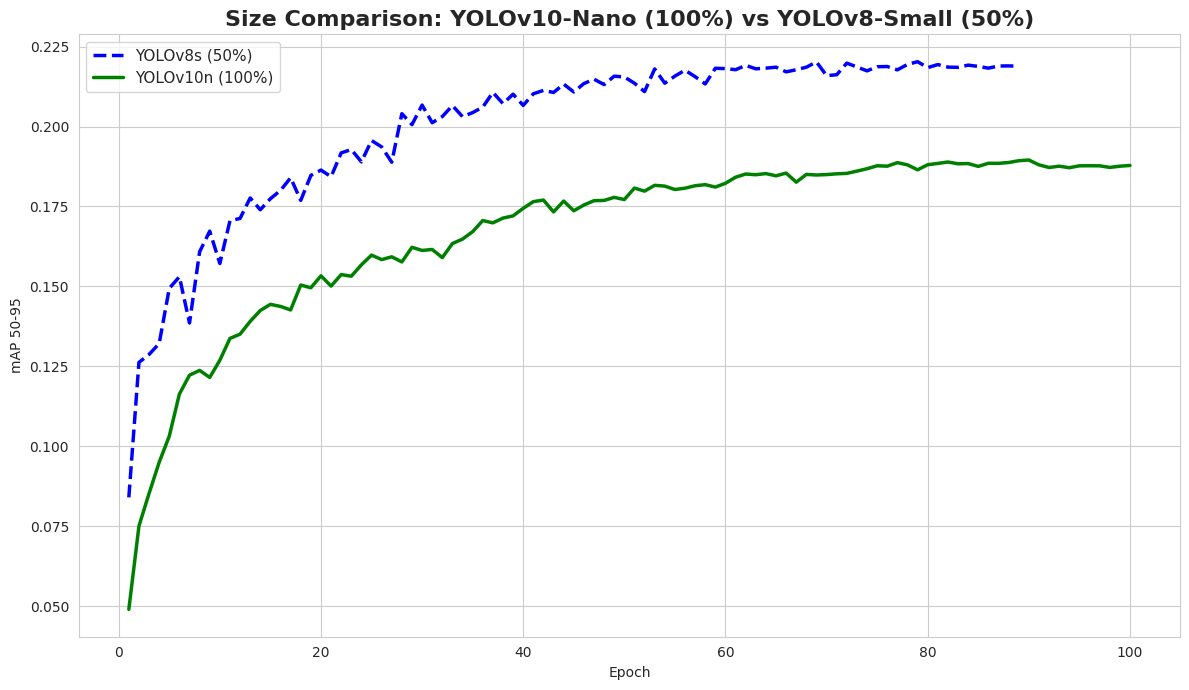

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

files_map = {
    # YOLOv8s 
    'v8s_25':  '/kaggle/input/training-results/results_v8s_25.csv',
    'v8s_50':  '/kaggle/input/training-results/results_v8s_50.csv',
    'v8s_100': '/kaggle/input/training-results/results_v8s_100.csv',
    
    # YOLOv10s
    'v10s_25':  '/kaggle/input/training-results/results_v10s_25.csv',
    'v10s_50':  '/kaggle/input/training-results/results_v10s_50.csv',
    'v10s_100': '/kaggle/input/training-results/results_v10s_100.csv',

    # YOLOv10n (Solo 100% disponibile)
    'v10n_100': '/kaggle/input/training-results/results_v10n_100.csv',
}

colors = {
    'v8s': 'blue', 
    'v10s': '#cc0000', # red
    'v10n': 'green'
}

# Styles for percentages
styles = {
    '25': ':',   
    '50': '--',     
    '100': '-'      
}

# Loading and cleaning
dfs = {}

for key, path in files_map.items():
    if path and os.path.exists(path):
        try:
            df = pd.read_csv(path)
            # Removes spaces from column names (e.g. ‘metrics/mAP...’ -> ‘metrics/mAP...’)
            df.columns = [c.strip() for c in df.columns]
            
            # Extract information from the key (e.g. “v8s_25” -> model=“v8s”, split=“25”)
            parts = key.split('_')
            model_type = parts[0]
            split_pct = parts[1]
            
            df['Model_Type'] = model_type
            df['Split'] = split_pct
            df['Label'] = f"YOLO{model_type} ({split_pct}%)"
            
            dfs[key] = df
        except Exception as e:
            print(f" Errore caricamento {key}: {e}")
    else:
        print(f" File mancante o path errato: {key}")

if not dfs:
    raise ValueError("Nessun dataframe caricato!")

# Generic plot function
def plot_curves(keys_to_plot, title, filename, zoom_epoch=None):
    plt.figure(figsize=(12, 7))
    sns.set_style("whitegrid")
    
    metric_col = 'metrics/mAP50-95(B)'
    
    valid_keys = [k for k in keys_to_plot if k in dfs]
    
    if not valid_keys:
        plt.close()
        return

    for key in valid_keys:
        df = dfs[key]
        model_type = df['Model_Type'].iloc[0]
        split = df['Split'].iloc[0]
        label = df['Label'].iloc[0]
        
        # Zoom filter
        data = df if zoom_epoch is None else df[df['epoch'] <= zoom_epoch]
        
        # Plot
        sns.lineplot(x=data['epoch'], y=data[metric_col], 
                     label=label, 
                     color=colors.get(model_type, 'gray'),
                     linestyle=styles.get(split, '-'),
                     linewidth=2.5)

    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('mAP 50-95')
    plt.legend(fontsize=11)
    
    if zoom_epoch:
        plt.xlim(0, zoom_epoch)
    
    plt.tight_layout()
    plt.savefig(f"{filename}.png", dpi=300)
    plt.show()

# Plot generation

# Plot A: Low-Data Regime (v8s vs v10s)
plot_curves(['v8s_25', 'v10s_25'], 
            "Low-Data Regime (25%)", 
            "Confronto_25pct")

# Plot B: Intermediate-Data Regime (v8s vs v10s)
plot_curves(['v8s_50', 'v10s_50'], 
            "Intermediate-Data Regime (50%)", 
            "Confronto_50pct")

# Plot C: Full-Data Regime (Tutti e 3 i modelli)
plot_curves(['v8s_100', 'v10s_100', 'v10n_100'], 
            "Full-Data Regime (100%)", 
            "Confronto_100pct")

# Plot D: Data Efficiency 
print("\n 2. Data Efficiency: YOLOv10s vs YOLOv8s vs YOLOv10n")
plot_curves(['v8s_100', 'v10s_50', 'v10n_100'], 
            "Efficiency Test: v10s(50%) vs v8s(100%) vs v10n(100%)", 
            "Data_Efficiency_Check")

# Plot E: ZOOM CONVERGENCE (All models at 100%)
print("\n 3. Convergence Speed (First 30 Epochs @ 100% Data)")
plot_curves(['v8s_100', 'v10s_100', 'v10n_100'], 
            "Convergence Speed (Full Data)", 
            "Speed_Convergence_Zoom", 
            zoom_epoch=30)

# Plot F: Nano Analysis
print("\n 4. Nano_10 100% vs Small_8 50%")
plot_curves(['v8s_50', 'v10n_100'], 
            "Size Comparison: YOLOv10-Nano (100%) vs YOLOv8-Small (50%)", 
            "Nano_vs_Small")


 Plot 1: Convergence Overview (All 100%)


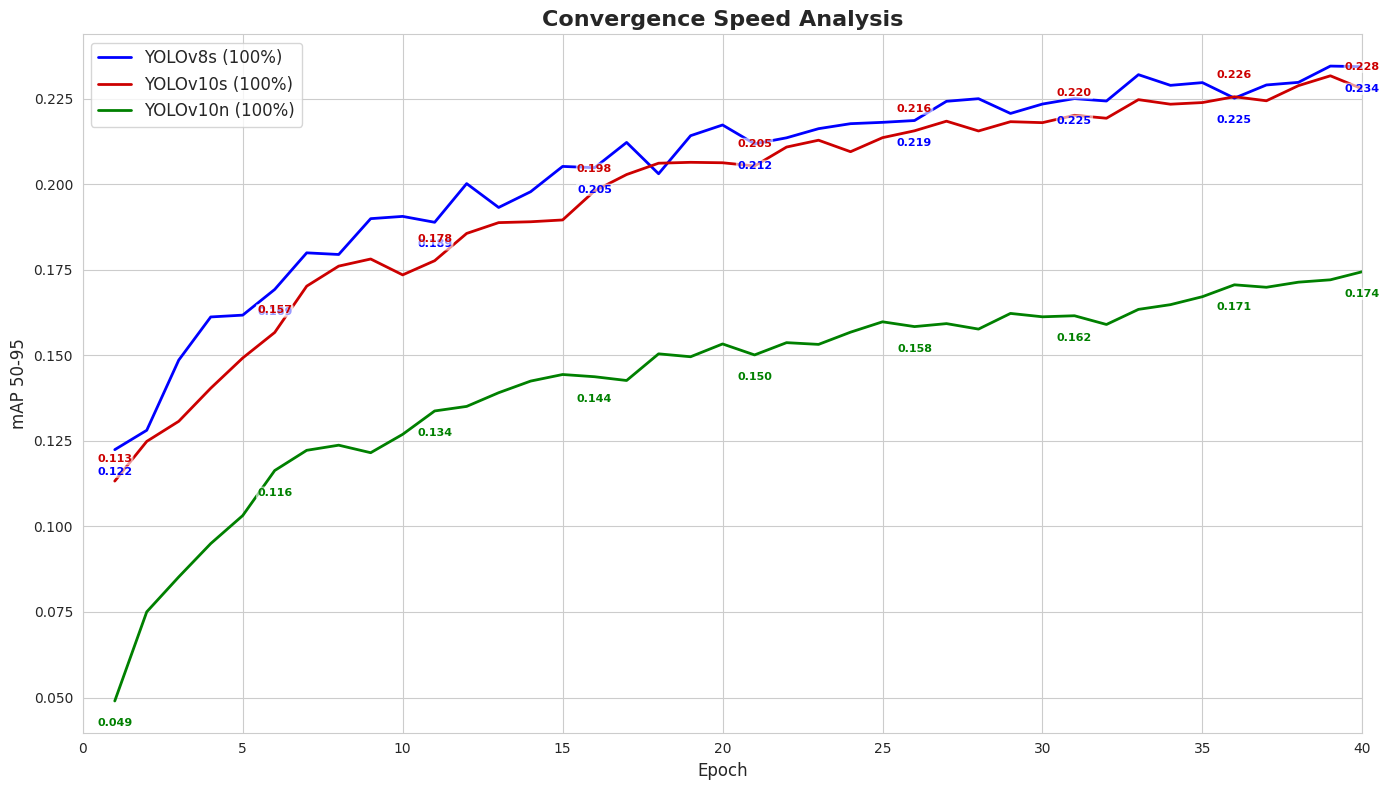


 Plot 2: Full Training (All 100%)


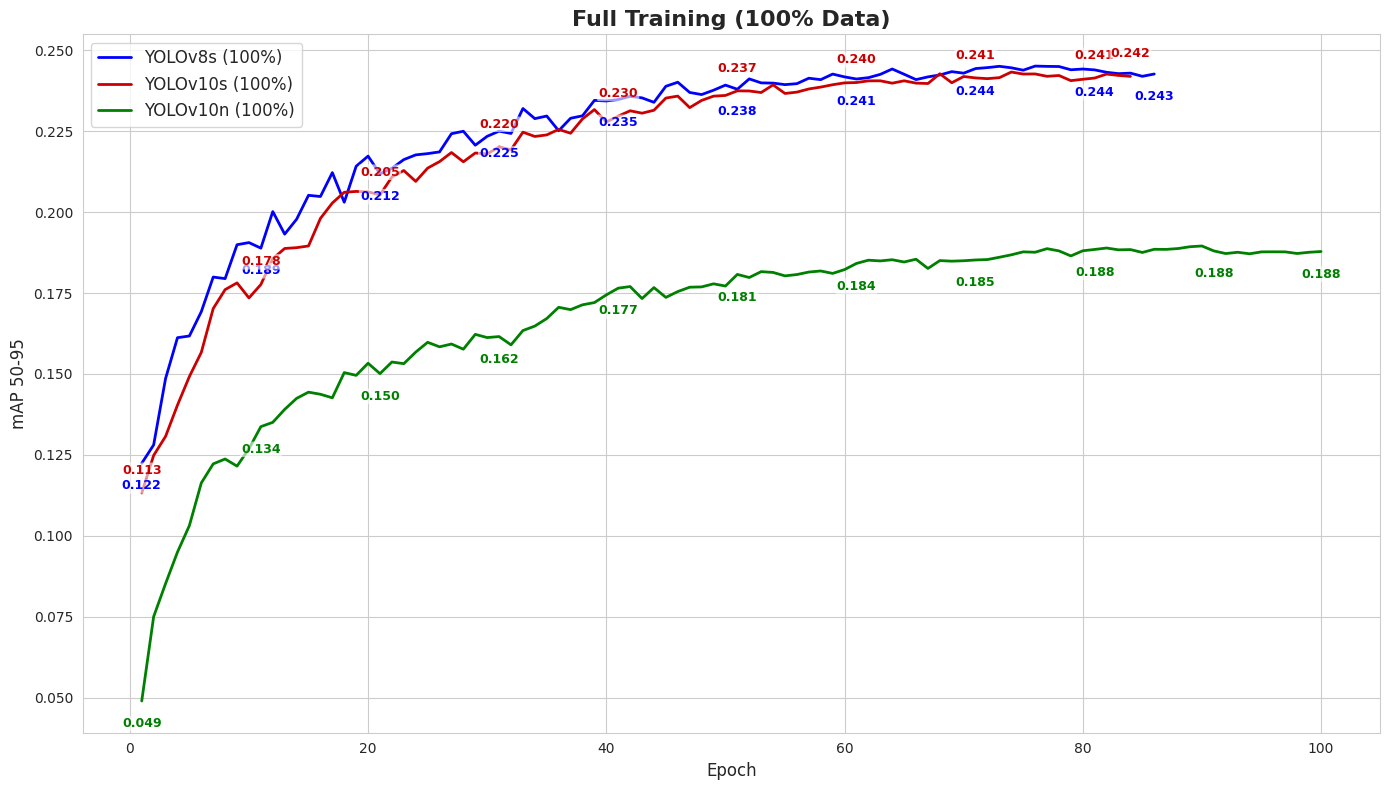


 Plot 3: Robustness (25% Data)


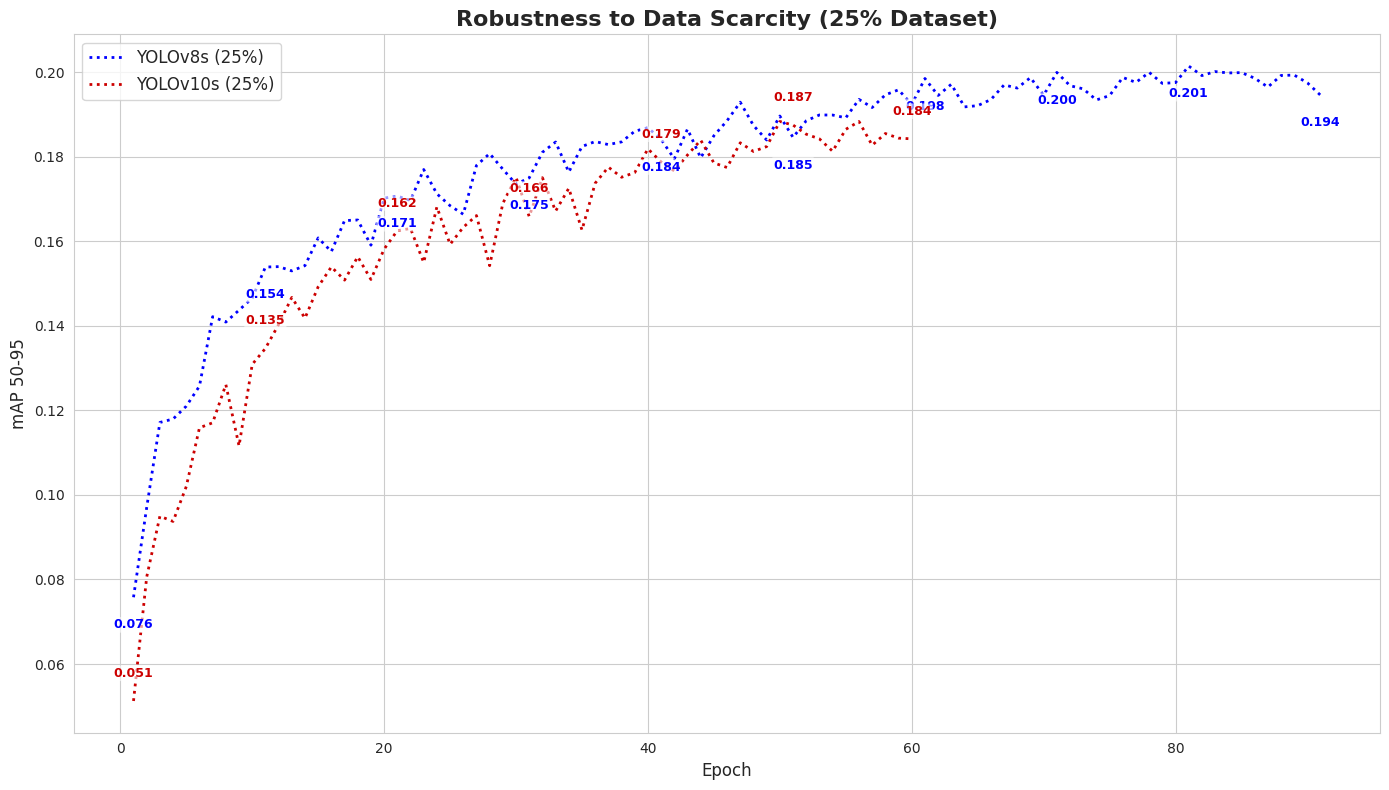


 Plot 4: Efficiency Challenge


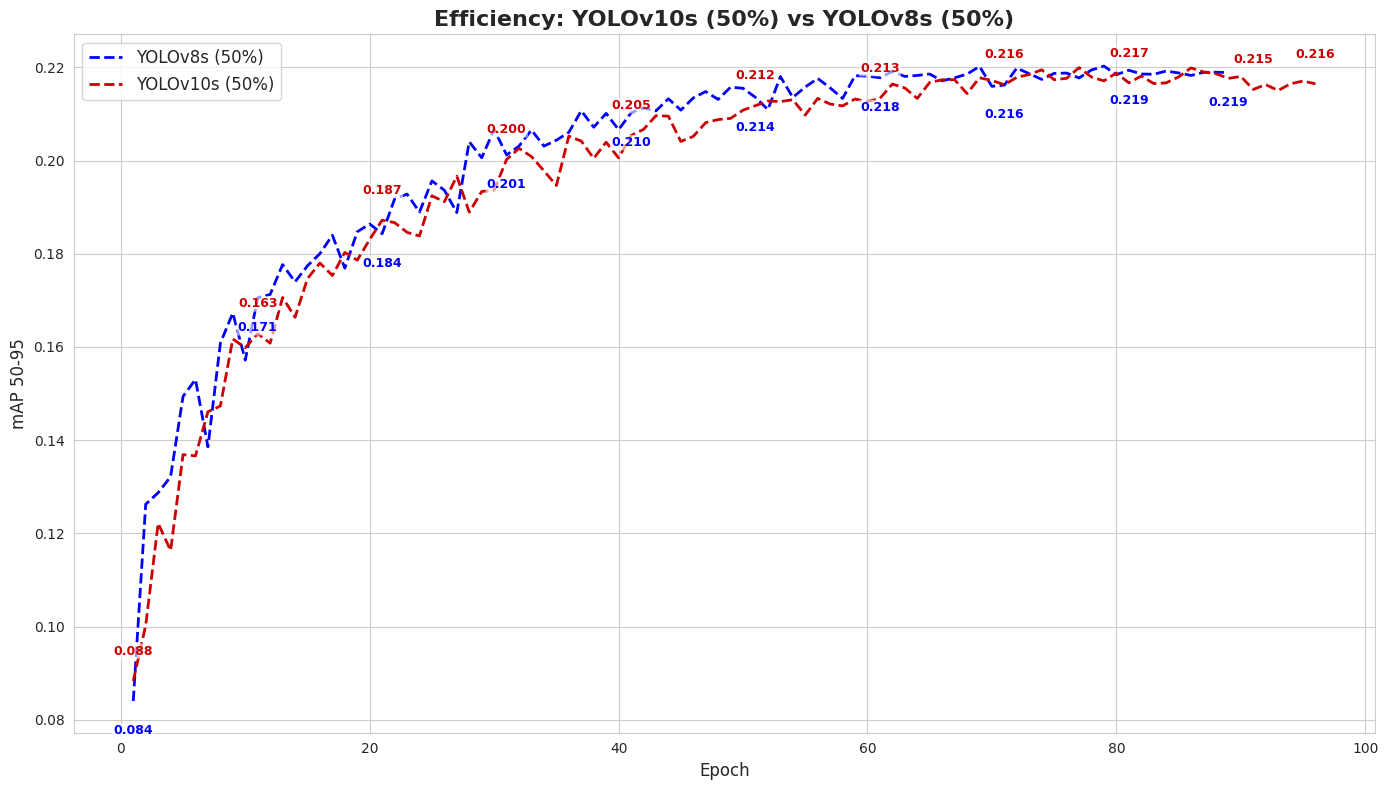

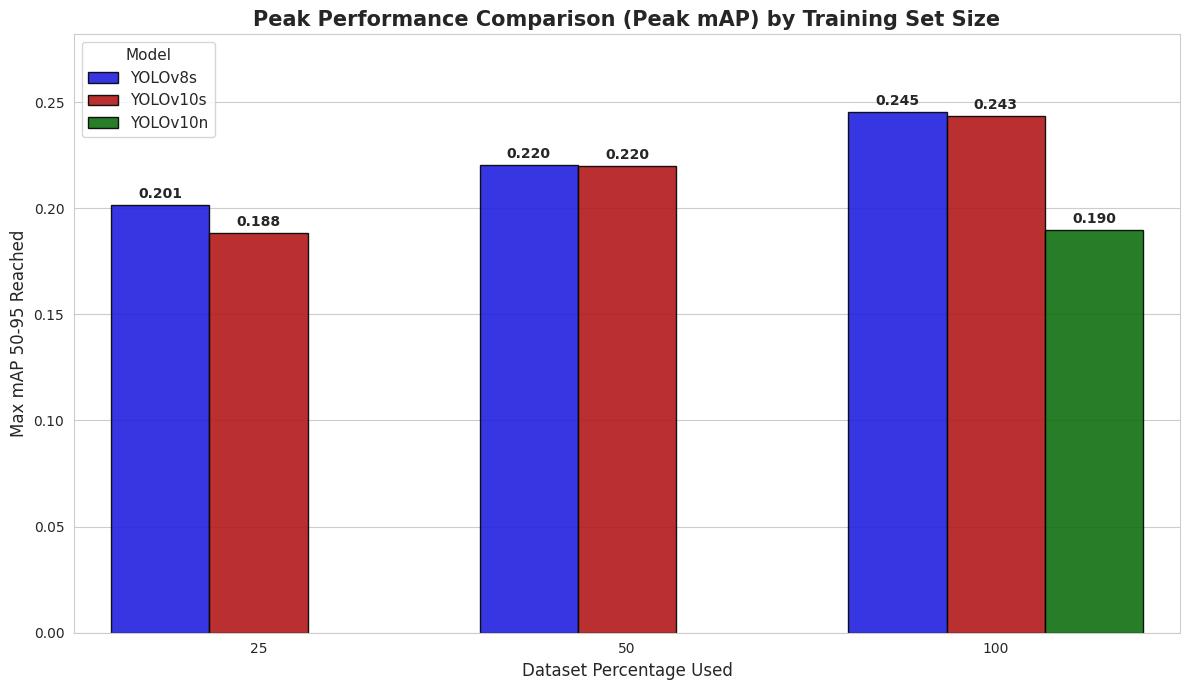

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np

# Configuration
files_map = {
    # YOLOv8s 
    'v8s_25':  '/kaggle/input/training-results/results_v8s_25.csv',
    'v8s_50':  '/kaggle/input/training-results/results_v8s_50.csv',
    'v8s_100': '/kaggle/input/training-results/results_v8s_100.csv',
    
    # YOLOv10s
    'v10s_25':  '/kaggle/input/training-results/results_v10s_25.csv',
    'v10s_50':  '/kaggle/input/training-results/results_v10s_50.csv',
    'v10s_100': '/kaggle/input/training-results/results_v10s_100.csv',

    # YOLOv10n (Solo 100% disponibile)
    'v10n_100': '/kaggle/input/training-results/results_v10n_100.csv',
}

colors = {'v8s': 'blue', 'v10s': '#cc0000', 'v10n': 'green'}
styles = {'25': ':', '50': '--', '100': '-'}
metric_col = 'metrics/mAP50-95(B)'

# Load data
dfs = {}
final_scores = [] 

for key, path in files_map.items():
    if path and os.path.exists(path):
        try:
            df = pd.read_csv(path)
            df.columns = [c.strip() for c in df.columns] 
            
            parts = key.split('_') 
            model = parts[0]
            split = parts[1]
            
            dfs[key] = df
            
            # For the summary chart
            max_map = df[metric_col].max()
            final_scores.append({
                'Model': f"YOLO{model}", 
                'Data_Pct': int(split), 
                'Max_mAP': max_map
            })
        except Exception as e:
            print(f"    Error {key}: {e}")
    else:
        print(f"File mancante: {key}")

# Plot function
def plot_training_curves(keys_list, title, filename, zoom_epoch=None):
    plt.figure(figsize=(14, 8))
    sns.set_style("whitegrid")
    
    # Determine the annotation interval
    if zoom_epoch and zoom_epoch <= 40:
        annotation_interval = 5 
        font_size = 8
    else:
        annotation_interval = 10 
        font_size = 9

    # Filter keys that actually exist in the loaded data
    valid_keys = [k for k in keys_list if k in dfs]

    if not valid_keys:
        print(f"Skipping plot '{title}': No valid data found.")
        plt.close()
        return

    for key in valid_keys:
        df = dfs[key]
        parts = key.split('_')
        model = parts[0]
        split = parts[1]
        label = f"YOLO{model} ({split}%)"
        color = colors[model]
        
        # Filter data
        data = df if zoom_epoch is None else df[df['epoch'] <= zoom_epoch]
        
        # Plot line
        sns.lineplot(x=data['epoch'], y=data[metric_col], 
                     label=label, color=color, linestyle=styles[split], linewidth=2)
        
        # Add values to the plot
        x_vals = data['epoch'].values
        y_vals = data[metric_col].values
        
        for i, (x, y) in enumerate(zip(x_vals, y_vals)):
            if i % annotation_interval == 0 or i == len(x_vals) - 1:
                
                va = 'bottom' if 'v10s' in key else 'top'
                offset = 0.005 if va == 'bottom' else -0.005
                
                plt.text(x, y + offset, f"{y:.3f}", 
                         color=color, fontsize=font_size, ha='center', va=va, fontweight='bold',
                         bbox=dict(boxstyle="round,pad=0.1", fc="white", ec="none", alpha=0.6)) 

    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('mAP 50-95', fontsize=12)
    plt.legend(fontsize=12)
    
    if zoom_epoch: 
        plt.xlim(0, zoom_epoch)
        if zoom_epoch <= 30:
            plt.xticks(np.arange(0, zoom_epoch+1, 2))
    
    plt.tight_layout()
    plt.savefig(f"{filename}.png", dpi=300)
    plt.show()

# Plot generation

print("\n Plot 1: Convergence Overview (All 100%)")
plot_training_curves(['v8s_100', 'v10s_100', 'v10n_100'], 
                     "Convergence Speed Analysis", 
                     "Chart1_Convergence_Analysis", zoom_epoch=40)

print("\n Plot 2: Full Training (All 100%)")
plot_training_curves(['v8s_100', 'v10s_100', 'v10n_100'], 
                     "Full Training (100% Data)", 
                     "Chart2_Full_Training", zoom_epoch=None)

print("\n Plot 3: Robustness (25% Data)")
plot_training_curves(['v8s_25', 'v10s_25'], 
                     "Robustness to Data Scarcity (25% Dataset)", 
                     "Chart3_Robustness_25", zoom_epoch=None)

print("\n Plot 4: Efficiency Challenge")
plot_training_curves(['v8s_50', 'v10s_50'], 
                     "Efficiency: YOLOv10s (50%) vs YOLOv8s (50%)", 
                     "Chart4_Efficiency_Challenge", zoom_epoch=None)


# Summary chart

if final_scores:
    df_final = pd.DataFrame(final_scores)
    df_final = df_final.sort_values(by='Data_Pct')

    plt.figure(figsize=(12, 7))
    sns.set_style("whitegrid")
    
    custom_palette = {'YOLOv8s': 'blue', 'YOLOv10s': '#cc0000', 'YOLOv10n': 'green'}

    ax = sns.barplot(data=df_final, x='Data_Pct', y='Max_mAP', hue='Model', 
                     palette=custom_palette, edgecolor='black', alpha=0.9)

    for container in ax.containers:
        ax.bar_label(container, fmt='%.3f', padding=3, fontsize=10, fontweight='bold')

    plt.title("Peak Performance Comparison (Peak mAP) by Training Set Size", fontsize=15, fontweight='bold')
    plt.xlabel("Dataset Percentage Used", fontsize=12)
    plt.ylabel("Max mAP 50-95 Reached", fontsize=12)
    plt.legend(title="Model", title_fontsize=11, fontsize=11, loc='upper left')
    plt.ylim(0, df_final['Max_mAP'].max() * 1.15) 

    plt.tight_layout()
    plt.savefig("Chart5_Summary_BarPlot.png", dpi=300)
    plt.show()
    
else:
    print(" No data found for summary chart.")

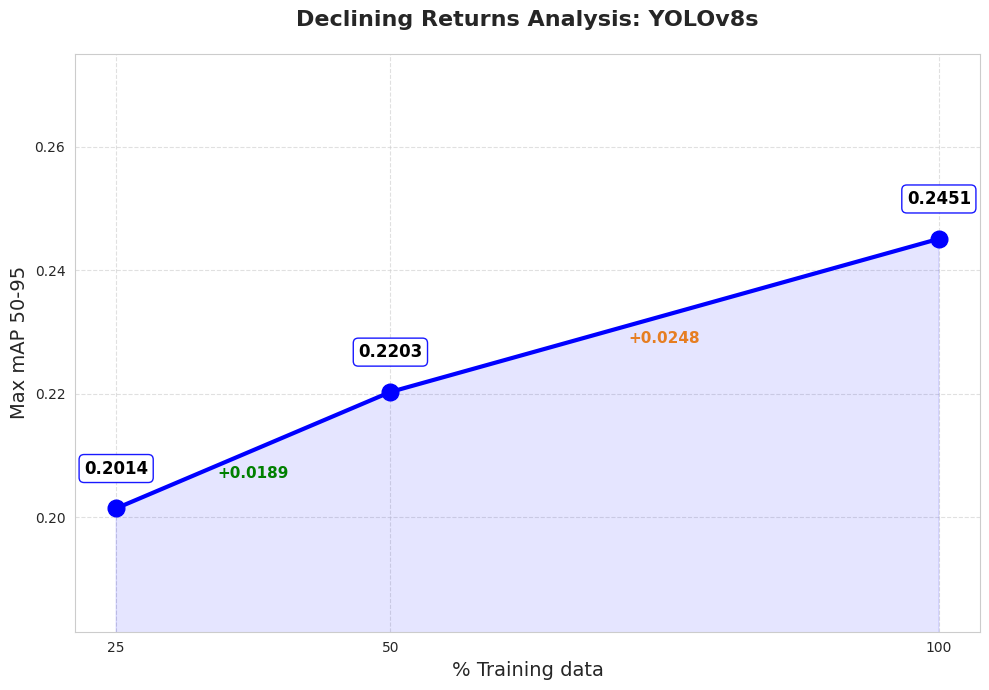

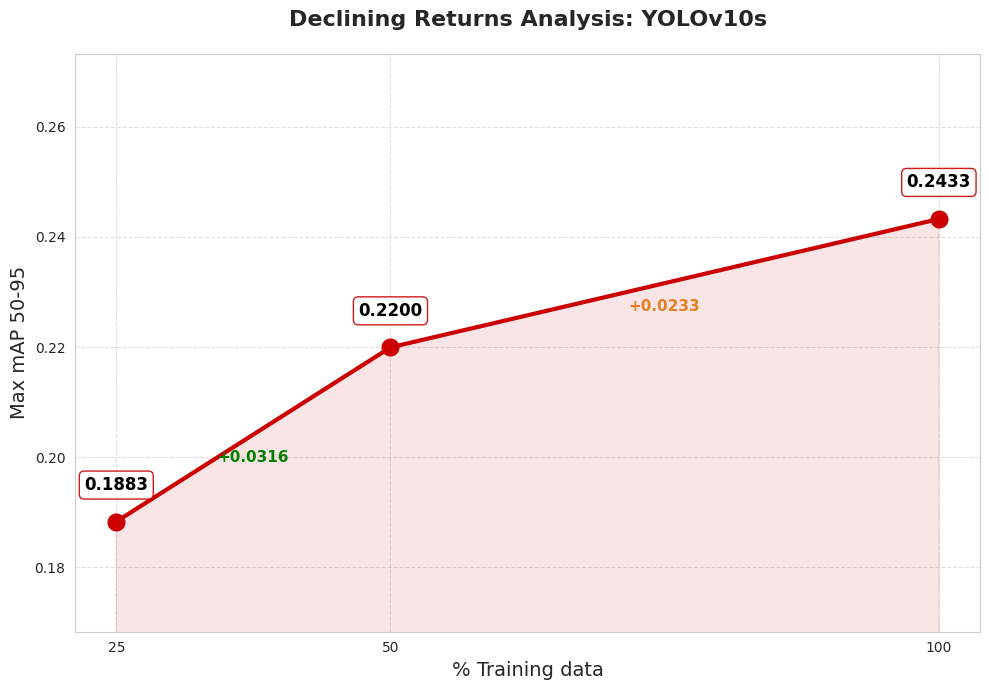

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np

# Configuration
files_map = {
    'YOLOv8s': {
        25: '/kaggle/input/training-results/results_v8s_25.csv',
        50: '/kaggle/input/training-results/results_v8s_50.csv',
        100: '/kaggle/input/training-results/results_v8s_100.csv'
    },
    'YOLOv10s': {
        25: '/kaggle/input/training-results/results_v10s_25.csv',
        50: '/kaggle/input/training-results/results_v10s_50.csv',
        100: '/kaggle/input/training-results/results_v10s_100.csv'
    },
    'YOLOv10n': {
        100: '/kaggle/input/training-results/results_v10n_100.csv'
    }
}

# Graphic configuration
model_colors = {'YOLOv8s': 'blue', 'YOLOv10s': '#cc0000', 'YOLOv10n': 'green'}
metric_col = 'metrics/mAP50-95(B)'
sns.set_style("whitegrid")

# Data extraction
data_summary = []

for model_name, splits in files_map.items():
    for pct, path in splits.items():
        if path and os.path.exists(path):
            try:
                df = pd.read_csv(path)
                df.columns = [c.strip() for c in df.columns] 
                best_map = df[metric_col].max()
                
                data_summary.append({
                    'Model': model_name,
                    'Data_Pct': pct,
                    'Max_mAP': best_map
                })
            except Exception as e:
                print(f"❌ Errore lettura {model_name} {pct}%: {e}")
        else:
            # Ignoriamo silenziosamente i file mancanti per v10n 25/50
            if model_name != 'YOLOv10n': 
                print(f"⚠️ File mancante: {model_name} {pct}%")

df_summary = pd.DataFrame(data_summary)

# Plot generation
models = ['YOLOv8s', 'YOLOv10s']

for model in models:
    subset = df_summary[df_summary['Model'] == model].sort_values('Data_Pct')
    
    if subset.empty:
        continue

    # Single Figure Creation
    plt.figure(figsize=(10, 7))
    
    x = subset['Data_Pct'].values
    y = subset['Max_mAP'].values
    color = model_colors.get(model, 'black')
    
    # Principal line
    plt.plot(x, y, marker='o', markersize=12, linewidth=3, color=color, label=model)
    
    plt.fill_between(x, y, alpha=0.1, color=color)
    
    # Exact values on the point
    for i in range(len(x)):
        # White box for an easy readability
        plt.text(x[i], y[i] + 0.005, f"{y[i]:.4f}", 
                 ha='center', va='bottom', fontsize=12, fontweight='bold', color='black',
                 bbox=dict(boxstyle="round,pad=0.3", fc="white", ec=color, alpha=0.9))

    # Earning annotations
    if len(x) == 3:
        # Gain 1: 25 -> 50
        gain_1 = y[1] - y[0]
        mid_x1 = (x[0] + x[1]) / 2
        mid_y1 = (y[0] + y[1]) / 2
        plt.annotate(f"+{gain_1:.4f}", xy=(mid_x1, mid_y1), 
                     ha='center', fontsize=11, color='green', fontweight='bold',
                     xytext=(0, -20), textcoords='offset points')

        # Gain 2: 50 -> 100
        gain_2 = y[2] - y[1]
        mid_x2 = (x[1] + x[2]) / 2
        mid_y2 = (y[1] + y[2]) / 2
        plt.annotate(f"+{gain_2:.4f}", xy=(mid_x2, mid_y2), 
                     ha='center', fontsize=11, color='#e67e22', fontweight='bold',
                     xytext=(0, -20), textcoords='offset points')

    # Titles and axes
    plt.title(f"Declining Returns Analysis: {model}", fontsize=16, fontweight='bold', pad=20)
    plt.ylabel('Max mAP 50-95', fontsize=14)
    plt.xlabel('% Training data', fontsize=14)
    plt.xticks([25, 50, 100])
    plt.grid(True, linestyle='--', alpha=0.6)
    
    if len(y) > 0:
        plt.ylim(min(y) - 0.02, max(y) + 0.03)

    plt.tight_layout()
    
    filename = f"DiminishingReturns_{model}.png"
    plt.savefig(filename, dpi=300)
    plt.show()

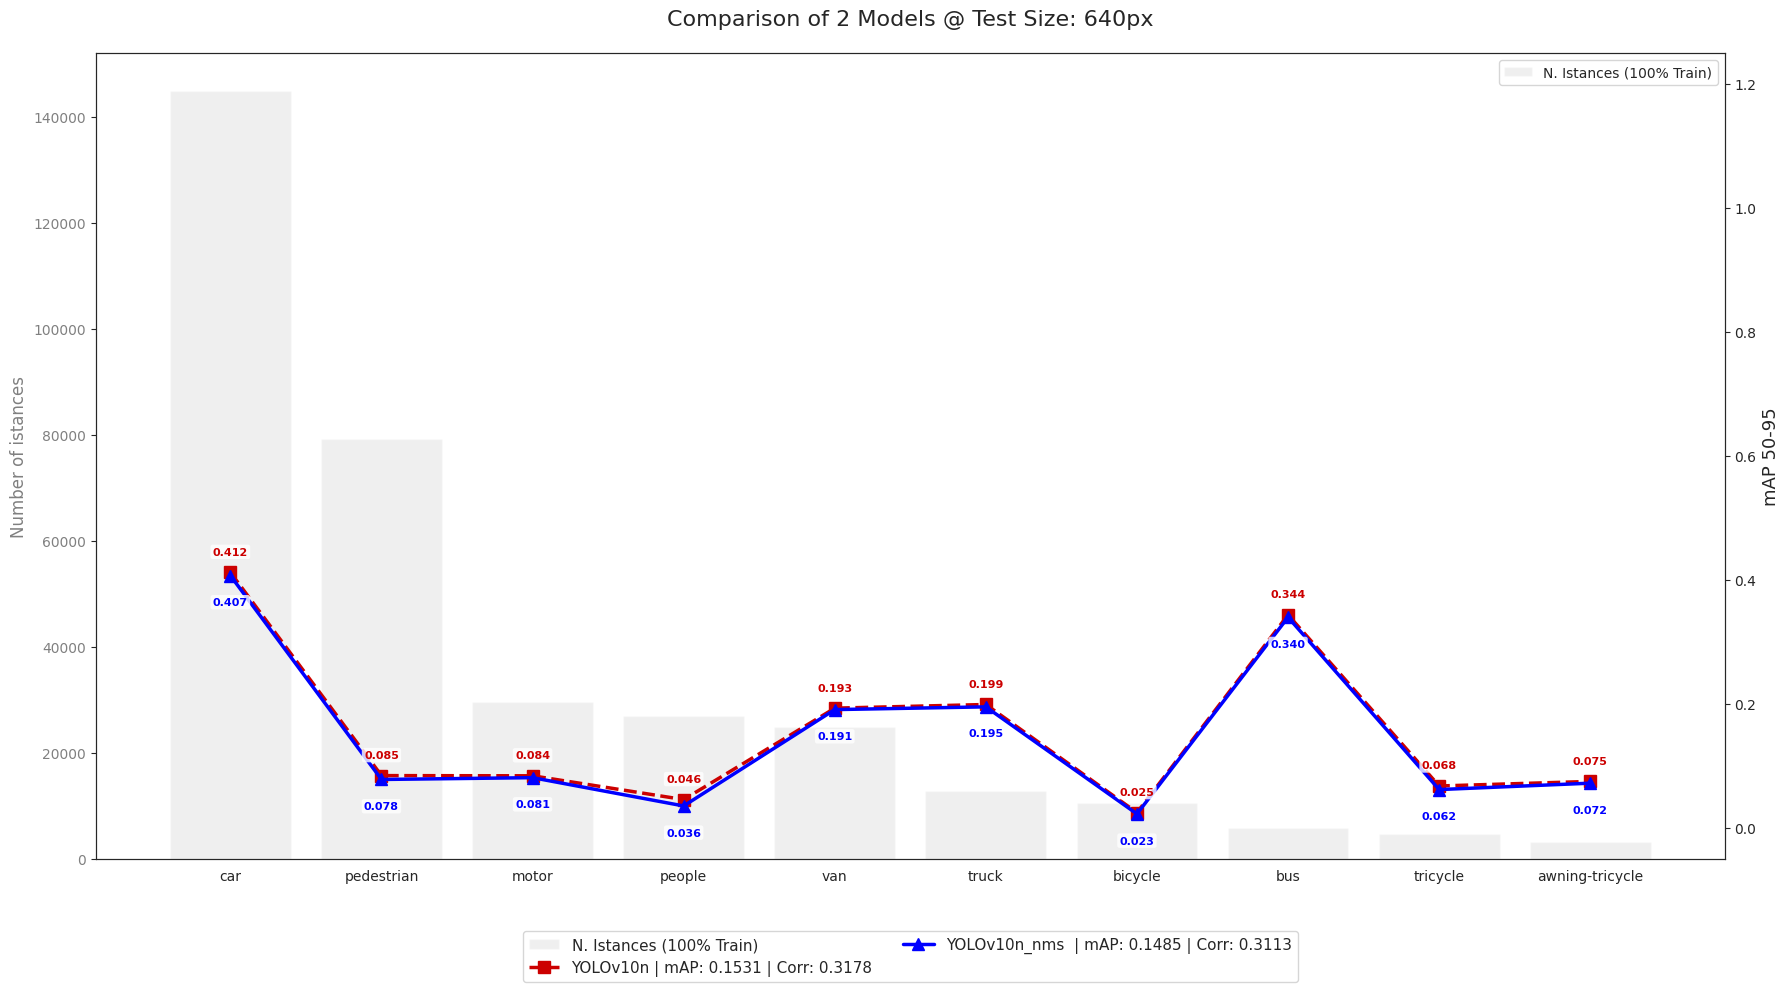

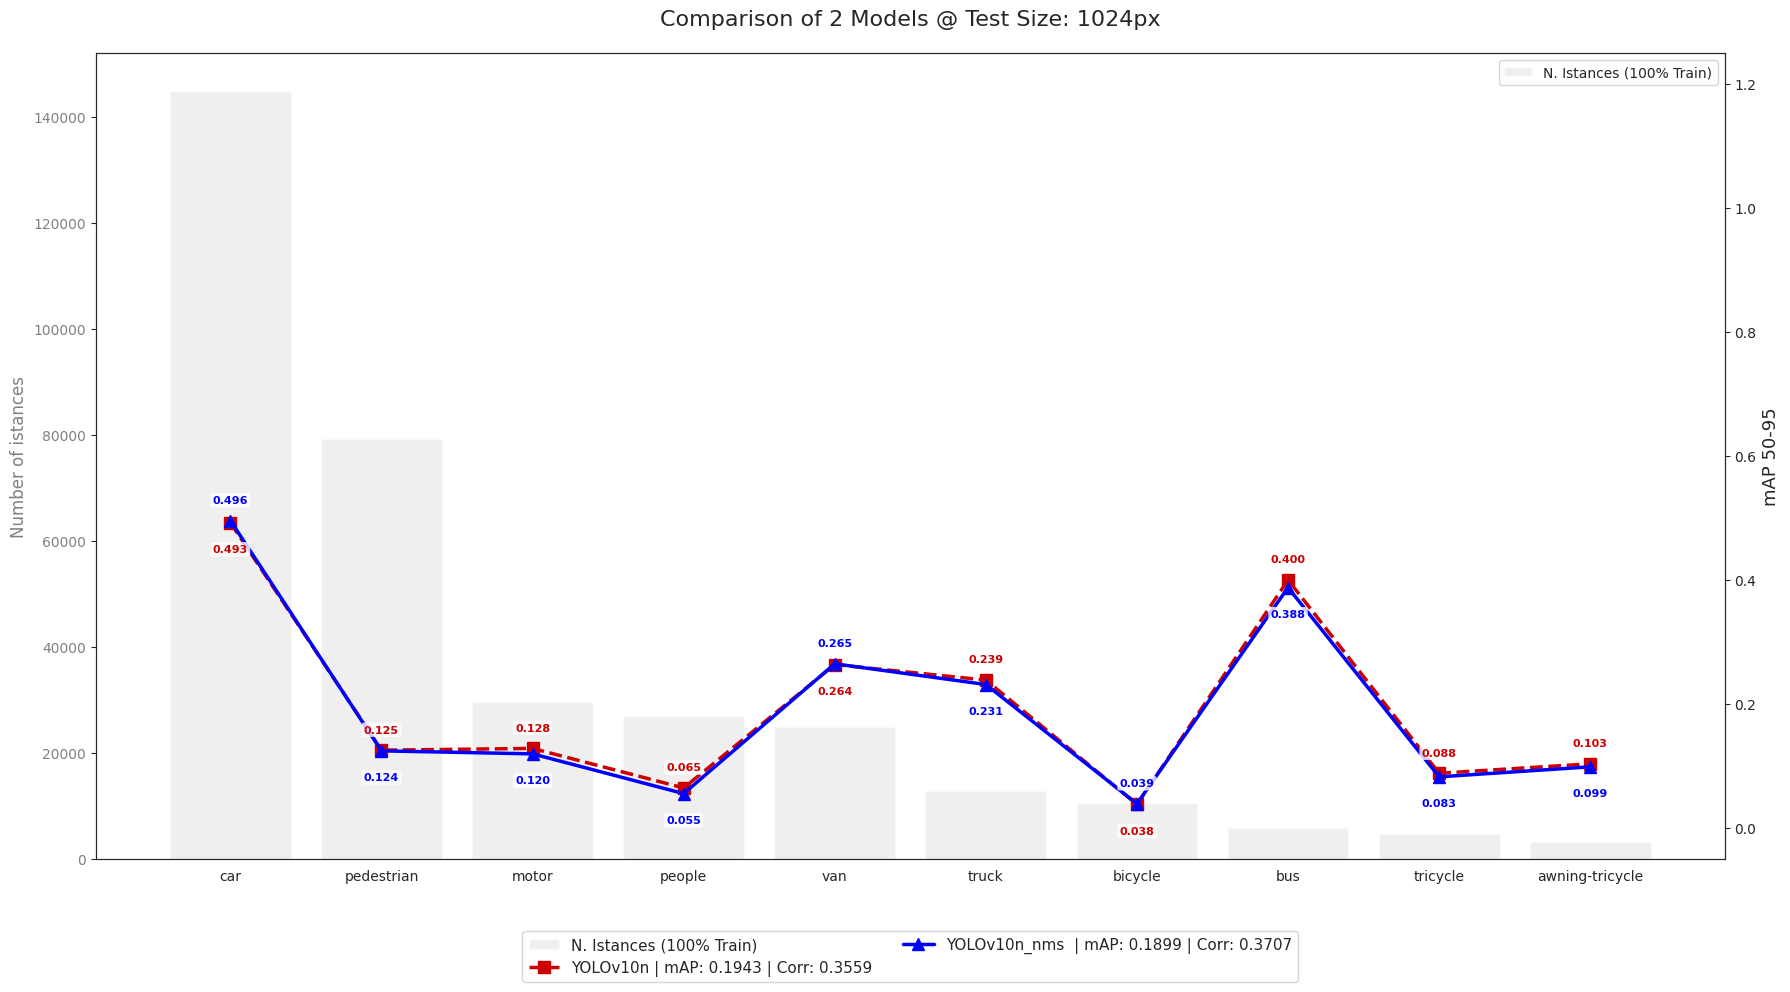

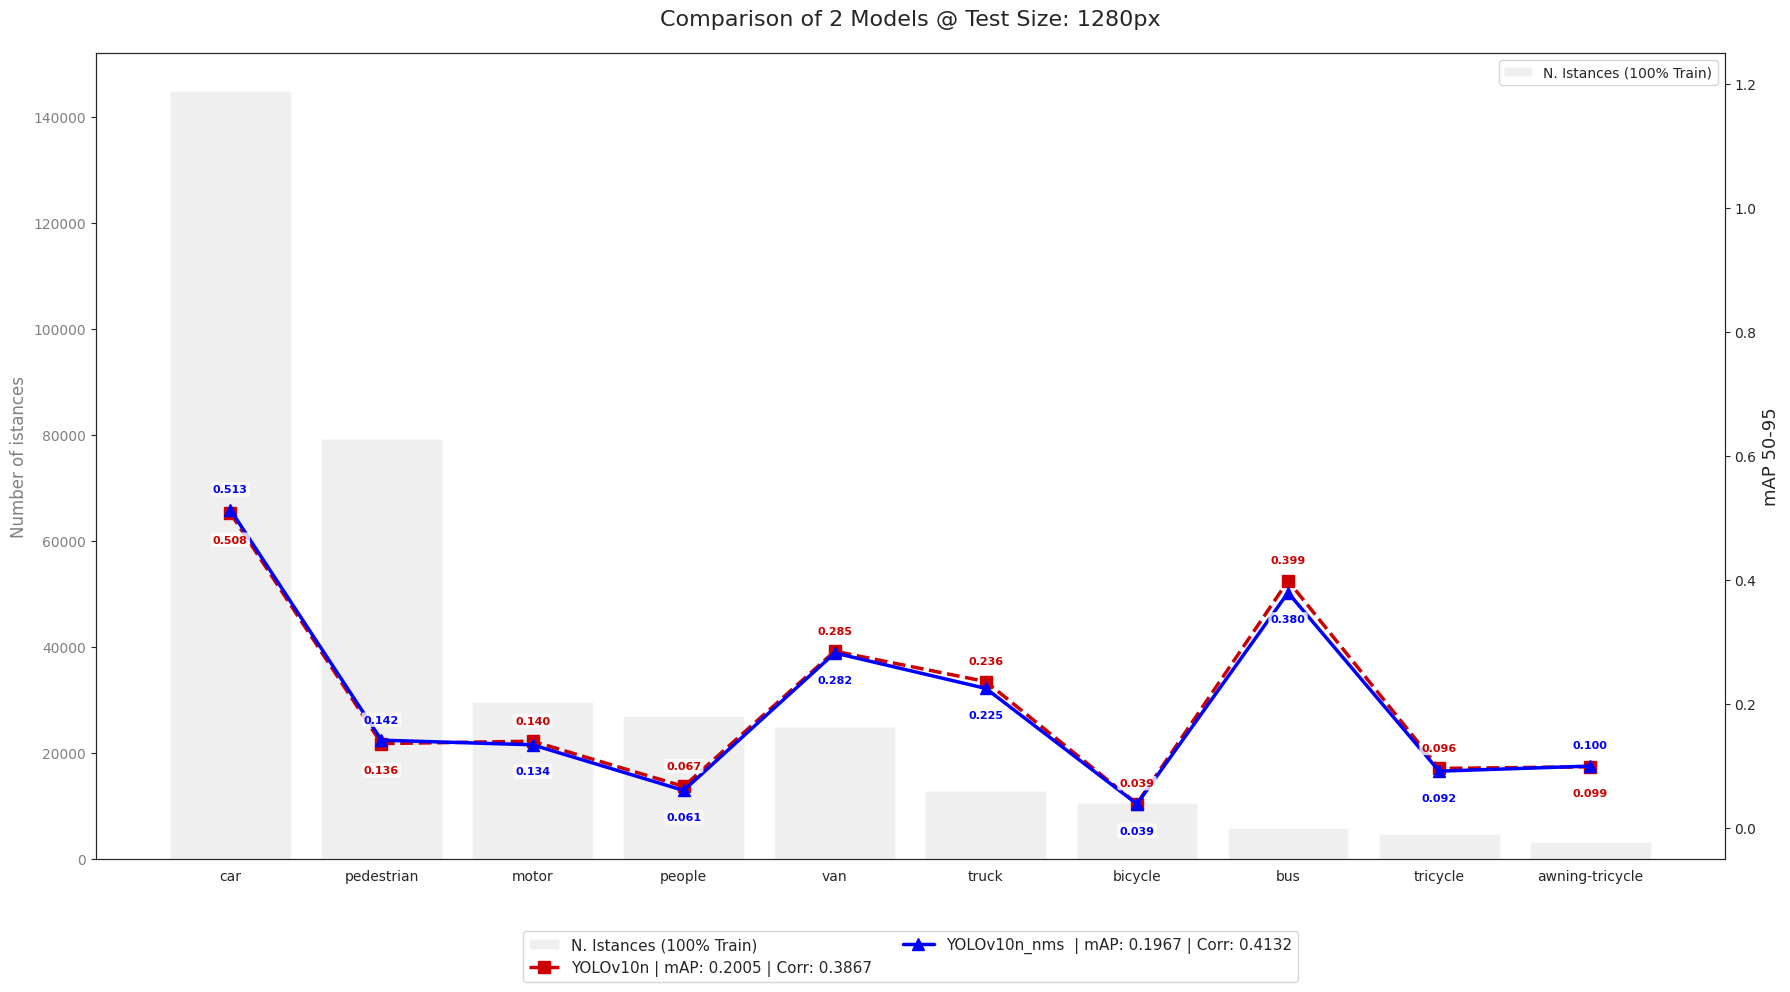

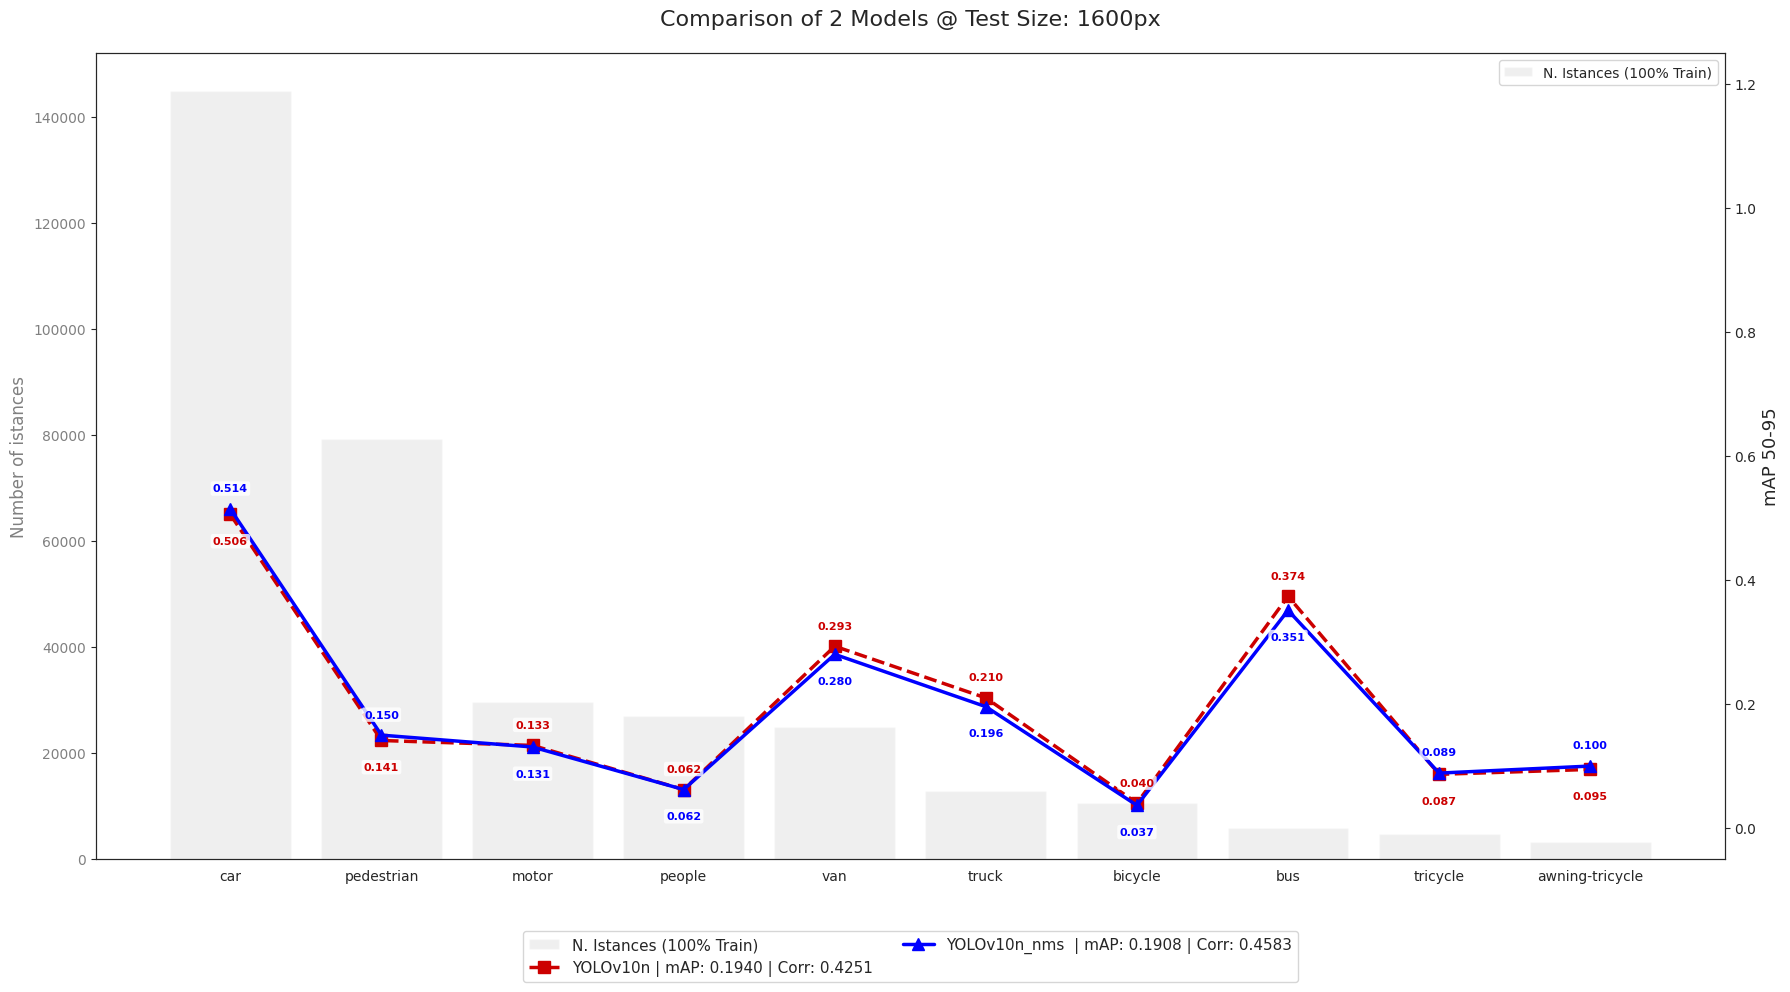

/kaggle/working/Grafici_Confronto_2Modelli_MultiScala.zip

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import shutil
import os
from IPython.display import FileLink

# Load and setup 
df_results = pd.read_csv('/kaggle/input/results/Risultati_Completi_Classi.csv') 
df_dist = pd.read_csv('/kaggle/input/results/Distribuzione_Classi_Splits.csv')      

output_dir = "Grafici_Confronto_Modelli_MultiScala"
if os.path.exists(output_dir):
    shutil.rmtree(output_dir)
os.makedirs(output_dir, exist_ok=True)

# Find all test resolutions available in csv
unique_test_resolutions = sorted(df_results['ImgSz'].unique())

# Definition of the target models
models_to_compare = [
    {
        "label": "YOLOv10n",
        "model_name": "YOLOv10n_100",
        "color": "#cc0000", # Rosso Scuro
        "marker": "s",
        "style": "--"
    },
    {
        "label": "YOLOv10n_nms ",
        "model_name": "YOLOv10n_nms_100",
        "color": "blue", # Arancione
        "marker": "^",
        "style": "-"
    }
]

# 100% distribution (fixed base)
dist_data = df_dist[['Class_Name', '100pct']].sort_values(by='100pct', ascending=False)
ordered_classes = dist_data['Class_Name'].tolist()
counts = dist_data['100pct'].values

sns.set_style("white")
bbox_props = dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=0.8)

# Test resolution loop
for test_res in unique_test_resolutions:
    
    plot_data = []
    
    # Filter the dataframe for the current test resolution
    df_current_res = df_results[df_results['ImgSz'] == test_res]
    
    missing_model = False
    
    for model_cfg in models_to_compare:
        # Create a copy so as not to change the original dictionary
        t = model_cfg.copy()
        
        # Look for the specific model in the current resolution
        row = df_current_res[df_current_res['Modello'] == t['model_name']]
        
        if row.empty:
            print(f" Dato mancante: {t['model_name']} non è stato testato a {test_res}px.")
            # Handling missing data
            # If a model is missing, it is generated with zeros.
            t['data'] = [0] * len(ordered_classes)
            t['gen_map'] = 0
            t['corr'] = 0
            missing_model = True
        else:
            m_aps = []
            gen_map = row['mAP50-95'].values[0]
            for cls in ordered_classes:
                col = f"{cls}_mAP50-95"
                val = row[col].values[0] if col in row.columns else 0
                m_aps.append(val)
            
            # Correlation computing
            corr = np.corrcoef(np.log1p(counts), m_aps)[0, 1]
            
            t['data'] = m_aps
            t['gen_map'] = gen_map
            t['corr'] = corr
            
        plot_data.append(t)

    # If all models are missing, skip
    if all(t['gen_map'] == 0 for t in plot_data):
        print(" Nessun dato disponibile per questa risoluzione. Salto.")
        continue

    # Plot
    fig, ax1 = plt.subplots(figsize=(18, 10))

    # Background (Distribution)
    sns.barplot(x=ordered_classes, y=counts, color='lightgray', alpha=0.35, ax=ax1, label='N. Istances (100% Train)')
    ax1.set_ylabel('Number of istances', fontsize=12, color='gray')
    ax1.tick_params(axis='y', labelcolor='gray')
    ax1.grid(False)

    # Lines (mAP)
    ax2 = ax1.twinx()

    for t in plot_data:
        label_text = f"{t['label']} | mAP: {t['gen_map']:.4f} | Corr: {t['corr']:.4f}"
        ax2.plot(ordered_classes, t['data'], marker=t['marker'], color=t['color'], 
                 linewidth=2.5, markersize=9, linestyle=t['style'], label=label_text)

    # Annotations
    for i in range(len(ordered_classes)):
        # Extract values for the current class 'i' across all models
        vals = [(t['data'][i], t_idx) for t_idx, t in enumerate(plot_data)]
        # Sort values from highest mAP to lowest to stack labels correctly
        vals_sorted = sorted(vals, key=lambda x: x[0], reverse=True)
        
        for rank, (val, model_idx) in enumerate(vals_sorted):
            t = plot_data[model_idx]
            
            # Dynamic offset to prevent overlapping text
            # Top label goes up, bottom goes down, others stay near the point
            if rank == 0:
                offset = 0.025
                va = 'bottom'
            elif rank == len(vals_sorted) - 1:
                offset = -0.035
                va = 'top'
            else:
                offset = 0.0
                va = 'center'
            
            ax2.text(i, val + offset, f"{val:.3f}", color=t['color'], 
                     ha='center', va=va, fontsize=8, fontweight='bold', bbox=bbox_props)

    ax2.set_ylabel('mAP 50-95', fontsize=13)
    ax2.set_ylim(-0.05, 1.25)
    
    plt.title(f'Comparison of 2 Models @ Test Size: {test_res}px', fontsize=16, pad=20)

    # Legend
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper center', bbox_to_anchor=(0.5, -0.08), ncol=2, fontsize=11)

    plt.tight_layout()

    filename = f"{output_dir}/Confronto_2Modelli_Test{test_res}.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

shutil.make_archive('Grafici_Confronto_2Modelli_MultiScala', 'zip', output_dir)
display(FileLink('Grafici_Confronto_2Modelli_MultiScala.zip'))

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

file_path = '/kaggle/input/results/Risultati_Completi_Classi.csv'
df = pd.read_csv(file_path)

# Calculating the F1 score
# Standard formula: 2 * (P * R) / (P + R)
# Handling any divisions by zero by adding a very small epsilon or handling NaNs
df['F1-Score'] = 2 * (df['Precision'] * df['Recall']) / (df['Precision'] + df['Recall'])
df['F1-Score'] = df['F1-Score'].fillna(0) # Se P+R è 0, metti 0

cols_to_keep = ['Modello', 'ImgSz', 'Precision', 'Recall', 'F1-Score', 'mAP50-95']
df_table = df[cols_to_keep].copy()

df_table = df_table.sort_values(by=['mAP50-95'], ascending=False)

# Rounding (4 decimal places)
df_table = df_table.round(4)

df_table.to_csv("Tabella_Metriche_Complete.csv", index=False)


 TABELLA COMPARATIVA METRICHE
          Modello  ImgSz  Precision  Recall  F1-Score  mAP50-95
YOLOv10s_100_1024   1600     0.5452  0.4608    0.4995    0.2706
YOLOv10s_100_1024   1280     0.5495  0.4521    0.4961    0.2686
YOLOv10s_100_1024   1024     0.5238  0.4269    0.4704    0.2538
     YOLOv10s_100   1280     0.5138  0.4191    0.4616    0.2412
      YOLOv8s_100   1280     0.5158  0.4163    0.4608    0.2386
     YOLOv10s_100   1024     0.5064  0.4115    0.4540    0.2383
      YOLOv8s_100   1024     0.4960  0.4124    0.4504    0.2340
     YOLOv10s_100   1600     0.4976  0.4106    0.4499    0.2329
      YOLOv8s_100   1600     0.4916  0.4085    0.4462    0.2288
      YOLOv10s_50   1280     0.4720  0.3935    0.4292    0.2198
       YOLOv8s_50   1280     0.4904  0.3878    0.4331    0.2168
      YOLOv10s_50   1024     0.4690  0.3905    0.4262    0.2165
       YOLOv8s_50   1024     0.4796  0.3864    0.4280    0.2137
      YOLOv10s_50   1600     0.4547  0.3883    0.4189    0.2073
       YO

<Figure size 1400x800 with 0 Axes>